In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import joblib
from pathlib import Path
import os

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()

        # Define feature categories
        price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                     '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        lag_cols = ['lag_1', 'lag_2', 'lag_3']

        # Load or fit scalers
        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        # Transform data
        df = self._transform_features(df, price_cols, volatility_cols, momentum_cols, lag_cols)

        # Create sequences
        X_scaled, y_scaled = self.create_sequences(df)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)

        # Split data
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)

        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        """Initialize and fit all scalers"""
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        """Apply feature transformations"""
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df

    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Position of 'close' in price_cols
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.001),
                       loss=tf.keras.losses.Huber(delta=1.3),  # Changed to Huber
                       metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=20):
        self.model.fit(X_train, y_train, 
                      validation_data=validation_data,
                      epochs=epochs,
                      callbacks=[EarlyStopping(patience=7)], 
                      batch_size=32, 
                      verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=55, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_train = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_train, y_train)

    def predict(self, X):
        return self.model.predict(X.reshape(X.shape[0], -1))

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.4),  # Changed to Huber
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=85):
        self.model.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=32,
                      callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)], 
                      verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"  # Directory to save models

        # Create directory if it doesn't exist
        os.makedirs(self.model_dir, exist_ok=True)

    def save_package(self, package_dir="crypto_predictor"):
        """Save complete pipeline as importable package"""
        pkg_path = Path(package_dir)
        pkg_path.mkdir(exist_ok=True)
        
        # Save pipeline
        joblib.dump(self.pipeline, pkg_path/"pipeline.pkl")
        
        # Save models
        (pkg_path/"models").mkdir(exist_ok=True)
        self.models['cnn_rnn'].model.save(pkg_path/"models/cnn_rnn")
        self.models['meta'].model.save(pkg_path/"models/meta_model")
        self.models['xgb'].model.save_model(pkg_path/"models/xgb_model.json")
        
        # Create __init__.py
        init_content = '''from pathlib import Path
import joblib
import tensorflow as tf
from xgboost import XGBRegressor

class CryptoPredictor:
    def __init__(self):
        self._load_artifacts()
        
    def _load_artifacts(self):
        base_path = Path(__file__).parent
        
        # Load pipeline
        self.pipeline = joblib.load(base_path/"pipeline.pkl")
        
        # Load models
        self.models = {
            'cnn_rnn': tf.keras.models.load_model(base_path/"models/cnn_rnn"),
            'meta': tf.keras.models.load_model(base_path/"models/meta_model"),
            'xgb': XGBRegressor(),
        }
        self.models['xgb'].load_model(base_path/"models/xgb_model.json")
        
    def predict(self, new_data):
        # Add your prediction logic here
        pass
'''
        with open(pkg_path/"__init__.py", "w") as f:
            f.write(init_content)

    @classmethod
    def load_package(cls, package_dir="crypto_predictor"):
        """Load from saved package"""
        return cls(package_dir)

    def save_models(self):
        """Save all models and pipeline to disk"""
        print("\nSaving models and pipeline...")
        
        # Save TensorFlow/Keras models
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))

        # Save XGBoost model
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))

        # Save pipeline with scalers
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)

        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        """Load all models and pipeline from disk"""
        print("\nLoading models and pipeline...")
        
        # Load TensorFlow/Keras models
        self.models['cnn_rnn'].model = tf.keras.models.load_model(
            os.path.join(self.model_dir, "cnn_rnn_model")
        )
        self.models['cnn_rnn_all_data'].model = tf.keras.models.load_model(
            os.path.join(self.model_dir, "cnn_rnn_all_data_model")
        )
        self.models['meta'].model = tf.keras.models.load_model(
            os.path.join(self.model_dir, "meta_model")
        )

        # Load XGBoost model
        self.models['xgb'].model = XGBRegressor()
        self.models['xgb'].model.load_model(
            os.path.join(self.model_dir, "xgb_model.json")
        )

        # Load pipeline with scalers
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "rb") as f:
            self.pipeline = pickle.load(f)

        print(f"Models and pipeline loaded from {self.model_dir}")

    def initialize_models(self, input_shape):
        self.models = {
            'cnn_rnn': HybridCNNRNN(input_shape),
            'xgb': SimpleXGBoost(),
            'cnn_rnn_all_data': HybridCNNRNN(input_shape),
            'meta': MetaModel((4,))
        }

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        # Base CNN-RNN model
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        
        # XGBoost model trained on all data
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        
        # CNN-RNN trained on all data
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        
        # Prepare meta-model data
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        # Generate predictions from all base models
        base_preds = [
            self.models['cnn_rnn'].model.predict(X_base).flatten(),
            self.models['xgb'].predict(X_base),
            [x[-1, 3] for x in X_base],  # Naive forecast from scaled data
            self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        ]
        return np.column_stack(base_preds)

    def predict_next_day(self, new_data):
        # Prepare input sequence
        seq_scaled, seq_unscaled = self._prepare_input_sequence(new_data)
        
        # Generate predictions
        base_preds = [
            self.models['cnn_rnn'].model.predict(seq_scaled).item(),
            self.models['xgb'].predict(seq_scaled).item(),
            seq_scaled[-1, 3],  # Naive forecast from raw data
            self.models['cnn_rnn_all_data'].model.predict(seq_scaled).item()
        ]
        
        # Get final prediction
        meta_pred = self.models['meta'].model.predict([base_preds]).item()
        return self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]

    def _prepare_input_sequence(self, new_data):
        # Update and maintain 30-day window
        self.full_data = pd.concat([self.full_data, new_data]).iloc[-30:]
        
        # Process data using existing scalers
        processed = self.pipeline.preprocess_data(
            self.full_data.copy(), 
            fit_scalers=False, 
            save_scalers=False
        )
        return processed[0][-1:], self.full_data.iloc[-30:].values[-1:]

    def update_models(self, new_data):
        # Update data storage
        self.full_data = pd.concat([self.full_data, new_data])
        
        # Process updated data
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(
            self.full_data, 
            fit_scalers=False
        )
        
        # Update models incrementally
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])

# ====================== Main Execution ======================
if __name__ == "__main__":
    # Initialize pipeline and load data
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    
    # Preprocess data
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, X_test_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    input_shape = X_train.shape[1:]

    # Prepare combined dataset for full-data models
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])

    # Initialize ALL models
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),  # Must be present
        'meta': MetaModel(input_shape=(4,)),
        'xgb': SimpleXGBoost()
        
    }

    # Initialize ensemble system
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.initialize_models(input_shape)
    ensemble.full_data = df.copy()

    # Train initial models
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()

        

    # Final evaluation
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.show()
    plt.savefig('predviz.jpeg')

SystemExit: usage: ipykernel_launcher.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: ipykernel_launcher.py --help [cmd1 cmd2 ...]
   or: ipykernel_launcher.py --help-commands
   or: ipykernel_launcher.py cmd --help

error: option --fullname must not have an argument

In [ ]:
def load_models(self):
    """Safer model loading"""
    print("\nLoading models and pipeline...")
    
    # Verify model directory exists
    if not os.path.exists(self.model_dir):
        raise FileNotFoundError(f"Model directory not found: {self.model_dir}")
    
    # Load pipeline first
    pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
    if os.path.exists(pipeline_path):
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
    
    # Load models with verification
    model_files = {
        'cnn_rnn': "cnn_rnn_model.keras",
        'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
        'meta': "meta_model.keras",
        'xgb': "xgb_model.json"
    }
    
    for key, filename in model_files.items():
        path = os.path.join(self.model_dir, filename)
        if not os.path.exists(path):
            print(f"Warning: Missing {filename}, skipping {key}")
            continue
            
        if key == 'xgb':
            self.models[key].model = XGBRegressor()
            self.models[key].model.load_model(path)
        else:
            self.models[key].model = tf.keras.models.load_model(path)
    
    print("Loading complete. Available models:", [k for k in self.models if self.models[k].model])

In [5]:
pip install statsmodels

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.0/9.8 MB 5.6 MB/s eta 0:00:02
   --------- ------------------------------ 2.4/9.8 MB 5.6 MB/s eta 0:00:02
   ------------- -------------------------- 3.4/9.8 MB 5.6 MB/s eta 0:00:02
   ------------------- -------------------- 4.7/9.8 MB 5.6 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.8 MB 5.7 MB/s eta 0:00:01
   ---------------------------- ----------- 7.1/9.8 MB 5.7 MB/s eta 0:00:01
   --------------------------------- ------ 8.1/9.8 MB 5.7 MB/s eta 0:00:01
   ------------------------------------- -- 9.2/9.8 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima.model import ARIMA

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Assuming 'close' is the 4th column in price_cols
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== ARIMA Model Definition ======================
class SimpleARIMA:
    """
    A simple ARIMA model for forecasting the 'close' price.
    Assumes y_train is a 1D series (scaled) of close prices.
    """
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model = None
        self.fitted_model = None

    def train(self, X_train, y_train):
        # Use y_train directly since it's already a 1D array.
        series = y_train  
        self.model = ARIMA(series, order=self.order)
        self.fitted_model = self.model.fit()

    def predict(self, X):
        if self.fitted_model is None:
            raise ValueError("ARIMA model is not trained yet.")
        forecast = self.fitted_model.forecast(steps=1)
        return np.array([forecast[0]])

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.001),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=20):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=7)],
                       batch_size=32,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=55, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        # Updated to accept 5 base predictions
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.4),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=80):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=32,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'arima': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        with open(os.path.join(self.model_dir, "arima_model.pkl"), "wb") as f:
            pickle.dump(self.models['arima'].model, f)
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json",
            'arima': "arima_model.pkl"
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            elif model_key == 'arima':
                self.models[model_key].model = pickle.load(open(path, "rb"))
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining ARIMA model...")
        self.models['arima'].train(X_train, y_train)  # ARIMA uses y_train series directly
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        base_preds = [
            self.models['cnn_rnn'].model.predict(X_base).flatten(),
            self.models['xgb'].predict(X_base),
            [x[-1, 3] for x in X_base],  # Naive forecast from scaled data
            self.models['cnn_rnn_all_data'].model.predict(X_base).flatten(),
            self.models['arima'].predict(X_base)  # ARIMA prediction returns a 1D array with one value
        ]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],  # Scaled 'close' from last row
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item(),
                self.models['arima'].predict(seq_scaled).item()  # ARIMA prediction
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            return final_pred
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        series = y_all  # Use the updated y_all series
        self.models['arima'].model = ARIMA(series, order=self.models['arima'].order)
        self.models['arima'].fitted_model = self.models['arima'].model.fit()

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((5,)),  # Updated meta input shape to 5
        'xgb': SimpleXGBoost(),
        'arima': SimpleARIMA(order=(1, 1, 1))
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # To make a new prediction, prepare a new DataFrame (new_data) with the same features.
    # predicted_close = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()


Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480

Training base CNN-RNN...
Epoch 1/20


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 7s - 120ms/step - loss: 0.0821 - mae: 0.2635 - mse: 0.1762 - val_loss: 0.8104 - val_mae: 0.9794 - val_mse: 2.9333
Epoch 2/20
60/60 - 1s - 21ms/step - loss: 0.0459 - mae: 0.2018 - mse: 0.0931 - val_loss: 0.8970 - val_mae: 0.9196 - val_mse: 3.9482
Epoch 3/20
60/60 - 1s - 20ms/step - loss: 0.0347 - mae: 0.1769 - mse: 0.0699 - val_loss: 0.9040 - val_mae: 0.9041 - val_mse: 3.9543
Epoch 4/20
60/60 - 1s - 22ms/step - loss: 0.0361 - mae: 0.1863 - mse: 0.0724 - val_loss: 0.9252 - val_mae: 0.9034 - val_mse: 4.0795
Epoch 5/20
60/60 - 1s - 21ms/step - loss: 0.0306 - mae: 0.1626 - mse: 0.0614 - val_loss: 0.8044 - val_mae: 0.8103 - val_mse: 3.3252
Epoch 6/20
60/60 - 1s - 20ms/step - loss: 0.0314 - mae: 0.1634 - mse: 0.0638 - val_loss: 0.8755 - val_mae: 0.8629 - val_mse: 3.8142
Epoch 7/20
60/60 - 1s - 20ms/step - loss: 0.0265 - mae: 0.1559 - mse: 0.0532 - val_loss: 0.9209 - val_mae: 0.9312 - val_mse: 4.1285
Epoch 8/20
60/60 - 1s - 20ms/step - loss: 0.0282 - mae: 0.1549 - mse: 0.0565 - val_los

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1918 and the array at index 4 has size 1

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima.model import ARIMA

import random

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)


# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Assuming 'close' is the 4th column in price_cols
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== ARIMA Model Definition ======================
class SimpleARIMA:
    """
    A simple ARIMA model for forecasting the 'close' price.
    Trains on the entire target series (e.g. y_all).
    """
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model = None
        self.fitted_model = None

    def train(self, X, y):
        # Use the entire y series (e.g., y_all) as the training series.
        series = y  # y is expected to be a 1D NumPy array.
        self.model = ARIMA(series, order=self.order)
        self.fitted_model = self.model.fit()

    def predict(self, X):
        if self.fitted_model is None:
            raise ValueError("ARIMA model is not trained yet.")
        forecast = self.fitted_model.forecast(steps=1)
        return np.array([forecast[0]])

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.001),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=20):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=7)],
                       batch_size=32,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=55, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        # Updated to accept 5 base predictions
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.4),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=80):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=32,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'arima': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        with open(os.path.join(self.model_dir, "arima_model.pkl"), "wb") as f:
            pickle.dump(self.models['arima'].model, f)
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json",
            'arima': "arima_model.pkl"
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            elif model_key == 'arima':
                self.models[model_key].model = pickle.load(open(path, "rb"))
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining ARIMA model on full target series...")
        # Use the entire y_all for ARIMA training.
        self.models['arima'].train(X_all, y_all)
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)


    def _prepare_meta_input(self, X_base, X_all, y_true):
        base_preds = [
            self.models['cnn_rnn'].model.predict(X_base).flatten(),
            self.models['xgb'].predict(X_base),
            [x[-1, 3] for x in X_base],  # Naive forecast from scaled data
            self.models['cnn_rnn_all_data'].model.predict(X_base).flatten(),
            self.models['arima'].predict(X_base)  # ARIMA prediction returns a 1D array with one value
        ]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],  # Scaled 'close' from last row
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item(),
                self.models['arima'].predict(seq_scaled).item()  # ARIMA prediction
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            return final_pred
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        series = y_all  # Use the updated y_all series
        self.models['arima'].model = ARIMA(series, order=self.models['arima'].order)
        self.models['arima'].fitted_model = self.models['arima'].model.fit()

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((5,)),  # Updated meta input shape to 5
        'xgb': SimpleXGBoost(),
        'arima': SimpleARIMA(order=(1, 1, 1))
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # To make a new prediction, prepare a new DataFrame (new_data) with the same features.
    # predicted_close = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()


Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480

Training base CNN-RNN...
Epoch 1/20


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 7s - 125ms/step - loss: 0.0782 - mae: 0.2586 - mse: 0.1672 - val_loss: 0.8760 - val_mae: 0.9443 - val_mse: 3.6272
Epoch 2/20
60/60 - 1s - 20ms/step - loss: 0.0420 - mae: 0.1865 - mse: 0.0848 - val_loss: 0.8055 - val_mae: 0.8560 - val_mse: 3.2586
Epoch 3/20
60/60 - 1s - 20ms/step - loss: 0.0365 - mae: 0.1794 - mse: 0.0733 - val_loss: 0.7762 - val_mae: 0.8151 - val_mse: 3.1793
Epoch 4/20
60/60 - 1s - 20ms/step - loss: 0.0388 - mae: 0.1824 - mse: 0.0777 - val_loss: 0.8337 - val_mae: 0.8320 - val_mse: 3.5849
Epoch 5/20
60/60 - 1s - 20ms/step - loss: 0.0328 - mae: 0.1693 - mse: 0.0659 - val_loss: 0.8361 - val_mae: 0.8540 - val_mse: 3.5961
Epoch 6/20
60/60 - 1s - 20ms/step - loss: 0.0329 - mae: 0.1672 - mse: 0.0667 - val_loss: 0.8042 - val_mae: 0.8469 - val_mse: 3.3885
Epoch 7/20
60/60 - 1s - 20ms/step - loss: 0.0278 - mae: 0.1573 - mse: 0.0556 - val_loss: 0.8863 - val_mae: 0.9520 - val_mse: 3.8159
Epoch 8/20
60/60 - 1s - 20ms/step - loss: 0.0267 - mae: 0.1524 - mse: 0.0536 - val_los

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1918 and the array at index 4 has size 1

Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480

Training base CNN-RNN...
Epoch 1/20


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 9s - 144ms/step - loss: 0.0971 - mae: 0.2795 - mse: 0.2112 - val_loss: 0.9334 - val_mae: 1.0528 - val_mse: 3.8067
Epoch 2/20
60/60 - 1s - 23ms/step - loss: 0.0440 - mae: 0.1925 - mse: 0.0897 - val_loss: 0.7662 - val_mae: 0.8275 - val_mse: 2.9591
Epoch 3/20
60/60 - 1s - 24ms/step - loss: 0.0396 - mae: 0.1821 - mse: 0.0798 - val_loss: 0.8868 - val_mae: 0.8718 - val_mse: 3.8426
Epoch 4/20
60/60 - 1s - 23ms/step - loss: 0.0362 - mae: 0.1753 - mse: 0.0726 - val_loss: 0.8025 - val_mae: 0.7951 - val_mse: 3.3206
Epoch 5/20
60/60 - 1s - 23ms/step - loss: 0.0328 - mae: 0.1697 - mse: 0.0657 - val_loss: 0.7897 - val_mae: 0.8105 - val_mse: 3.2152
Epoch 6/20
60/60 - 1s - 23ms/step - loss: 0.0357 - mae: 0.1730 - mse: 0.0718 - val_loss: 0.7858 - val_mae: 0.8154 - val_mse: 3.2731
Epoch 7/20
60/60 - 1s - 23ms/step - loss: 0.0303 - mae: 0.1663 - mse: 0.0609 - val_loss: 0.8500 - val_mae: 0.8881 - val_mse: 3.5553
Epoch 8/20
60/60 - 1s - 23ms/step - loss: 0.0300 - mae: 0.1607 - mse: 0.0611 - val_los

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 - 0s - 3ms/step - loss: 0.0041 - mae: 0.0554 - mse: 0.0083 - learning_rate: 8.0000e-04
Epoch 4/70
60/60 - 0s - 3ms/step - loss: 0.0032 - mae: 0.0489 - mse: 0.0064 - learning_rate: 8.0000e-04
Epoch 5/70
60/60 - 0s - 3ms/step - loss: 0.0025 - mae: 0.0455 - mse: 0.0050 - learning_rate: 8.0000e-04
Epoch 6/70
60/60 - 0s - 3ms/step - loss: 0.0017 - mae: 0.0390 - mse: 0.0035 - learning_rate: 8.0000e-04
Epoch 7/70
60/60 - 0s - 3ms/step - loss: 0.0012 - mae: 0.0330 - mse: 0.0023 - learning_rate: 8.0000e-04
Epoch 8/70
60/60 - 0s - 2ms/step - loss: 0.0011 - mae: 0.0326 - mse: 0.0022 - learning_rate: 8.0000e-04
Epoch 9/70
60/60 - 0s - 3ms/step - loss: 9.6563e-04 - mae: 0.0305 - mse: 0.0019 - learning_rate: 8.0000e-04
Epoch 10/70
60/60 - 0s - 3ms/step - loss: 0.0012 - mae: 0.0344 - mse: 0.0023 - learning_rate: 8.0000e-04
Epoch 11/70
60/60 - 0s - 3ms/step - loss: 0.0011 - mae: 0.0339 - mse: 0.0022 - learning_rate: 8.0000e-04
Epoch 12/70
60/60 - 0s - 3ms/step - loss: 8.9994e-04 - mae: 0.0308 - 

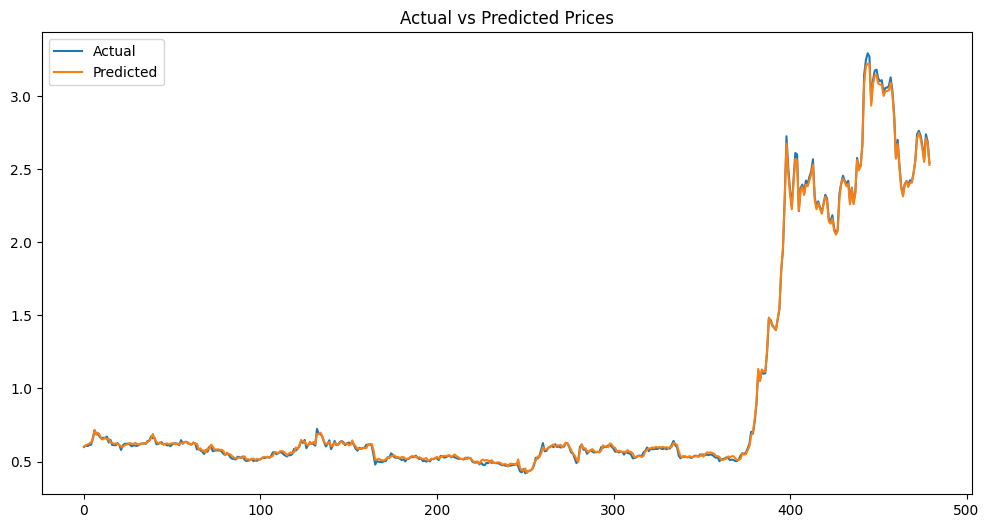

In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Assuming 'close' is the 4th column in price_cols
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== SES Model Definition ======================
class SimpleSES:
    """
    A simple exponential smoothing (SES) model for forecasting the 'close' price.
    For each input sample (sequence), it extracts the last 30-day 'close' series and
    dynamically fits a SimpleExpSmoothing model to forecast one step ahead.
    """
    def __init__(self):
        # No persistent model is stored, forecasts are computed dynamically.
        pass

    def train(self, X, y):
        # In this dynamic approach, we do not pre-train a global SES model.
        pass

    def predict(self, X):
        forecasts = []
        for sample in X:
            close_series = sample[:, 3]  # Assuming 'close' is at index 3
            try:
                model = SimpleExpSmoothing(close_series)
                fitted_model = model.fit(optimized=True)
                forecast = fitted_model.forecast(steps=1)[0]
            except Exception as e:
                forecast = close_series[-1]
            forecasts.append(forecast)
        return np.array(forecasts)

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.001),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=20):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=7)],
                       batch_size=32,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=55, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        # Updated to accept 5 base predictions
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=70):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=32,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'ses': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        # We do not save a SES model because forecasts are computed dynamically.
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json",
            'ses': None  # SES is computed dynamically, so no file to load.
        }
        for model_key, filename in model_paths.items():
            if model_key == 'ses':
                continue  # Skip loading SES.
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining SES model on full target series (global training is not used, forecasts are dynamic)...")
        # SES dynamic forecasting does not require pre-training.
        # But you could optionally store the series here if desired.
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        ses_preds = self.models['ses'].predict(X_base)
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, cnn_rnn_all_data_preds, ses_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item(),
                self.models['ses'].predict(seq_scaled).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            return final_pred
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        # SES model doesn't need update since forecasts are computed dynamically.

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((5,)),  # Meta-model expects 5 inputs now.
        'xgb': SimpleXGBoost(),
        'ses': SimpleSES()
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # To predict a new day's close price, prepare a DataFrame 'new_data' with the same features.
    # Example:
    # predicted_close = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()


Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480

Training base CNN-RNN...
Epoch 1/20


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 16s - 267ms/step - loss: 0.0920 - mae: 0.2782 - mse: 0.1946 - val_loss: 0.8459 - val_mae: 0.9887 - val_mse: 3.1470
Epoch 2/20
60/60 - 1s - 21ms/step - loss: 0.0511 - mae: 0.2060 - mse: 0.1064 - val_loss: 0.8208 - val_mae: 0.8628 - val_mse: 3.3489
Epoch 3/20
60/60 - 1s - 21ms/step - loss: 0.0386 - mae: 0.1786 - mse: 0.0775 - val_loss: 0.8504 - val_mae: 0.8354 - val_mse: 3.5774
Epoch 4/20
60/60 - 1s - 21ms/step - loss: 0.0434 - mae: 0.1887 - mse: 0.0883 - val_loss: 0.8713 - val_mae: 0.8721 - val_mse: 3.7541
Epoch 5/20
60/60 - 1s - 21ms/step - loss: 0.0355 - mae: 0.1709 - mse: 0.0716 - val_loss: 0.7238 - val_mae: 0.7437 - val_mse: 2.8443
Epoch 6/20
60/60 - 1s - 21ms/step - loss: 0.0311 - mae: 0.1621 - mse: 0.0625 - val_loss: 0.8081 - val_mae: 0.8581 - val_mse: 3.3331
Epoch 7/20
60/60 - 1s - 21ms/step - loss: 0.0368 - mae: 0.1718 - mse: 0.0743 - val_loss: 0.9459 - val_mae: 1.0227 - val_mse: 4.1971
Epoch 8/20
60/60 - 2s - 35ms/step - loss: 0.0279 - mae: 0.1556 - mse: 0.0559 - val_lo

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


60/60 - 0s - 3ms/step - loss: 0.0021 - mae: 0.0427 - mse: 0.0042 - learning_rate: 8.0000e-04
Epoch 4/70
60/60 - 0s - 3ms/step - loss: 0.0014 - mae: 0.0360 - mse: 0.0027 - learning_rate: 8.0000e-04
Epoch 5/70
60/60 - 0s - 3ms/step - loss: 0.0012 - mae: 0.0345 - mse: 0.0023 - learning_rate: 8.0000e-04
Epoch 6/70
60/60 - 0s - 3ms/step - loss: 0.0019 - mae: 0.0402 - mse: 0.0039 - learning_rate: 8.0000e-04
Epoch 7/70
60/60 - 0s - 3ms/step - loss: 0.0012 - mae: 0.0350 - mse: 0.0024 - learning_rate: 8.0000e-04
Epoch 8/70
60/60 - 0s - 3ms/step - loss: 9.2782e-04 - mae: 0.0311 - mse: 0.0019 - learning_rate: 8.0000e-04
Epoch 9/70
60/60 - 0s - 3ms/step - loss: 8.2335e-04 - mae: 0.0291 - mse: 0.0016 - learning_rate: 8.0000e-04
Epoch 10/70
60/60 - 0s - 3ms/step - loss: 8.7192e-04 - mae: 0.0311 - mse: 0.0017 - learning_rate: 8.0000e-04
Epoch 11/70
60/60 - 0s - 3ms/step - loss: 9.2491e-04 - mae: 0.0311 - mse: 0.0018 - learning_rate: 8.0000e-04
Epoch 12/70
60/60 - 0s - 3ms/step - loss: 9.0406e-04 - ma

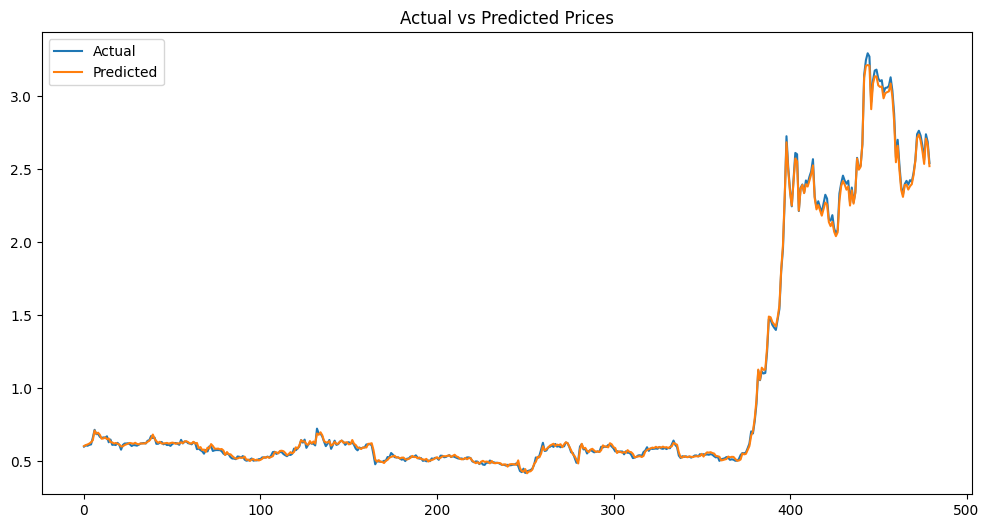

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Index of 'close' in price_cols
            # Convert to numpy array for numerical operations
            pred_scaled = np.array(pred_scaled)
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== SES Model Definition ======================
class SimpleSES:
    """
    A simple exponential smoothing (SES) model for forecasting the 'close' price.
    For each input sample (sequence), it extracts the last 30-day 'close' series and
    dynamically fits a SimpleExpSmoothing model to forecast one step ahead.
    """
    def __init__(self):
        # No persistent model is stored, forecasts are computed dynamically.
        pass

    def train(self, X, y):
        # In this dynamic approach, we do not pre-train a global SES model.
        pass

    def predict(self, X):
        forecasts = []
        for sample in X:
            close_series = sample[:, 3]  # Assuming 'close' is at index 3
            try:
                model = SimpleExpSmoothing(close_series)
                fitted_model = model.fit(optimized=True)
                forecast = fitted_model.forecast(steps=1)[0]
            except Exception as e:
                forecast = close_series[-1]
            forecasts.append(forecast)
        return np.array(forecasts)

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.001),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=20):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=7)],
                       batch_size=32,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=55, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        # Updated to accept 5 base predictions
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.2),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=70):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=32,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'ses': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        # We do not save a SES model because forecasts are computed dynamically.
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json",
            'ses': None  # SES is computed dynamically, so no file to load.
        }
        for model_key, filename in model_paths.items():
            if model_key == 'ses':
                continue  # Skip loading SES.
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining SES model on full target series (global training is not used, forecasts are dynamic)...")
        # SES dynamic forecasting does not require pre-training.
        # But you could optionally store the series here if desired.
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        ses_preds = self.models['ses'].predict(X_base)
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, cnn_rnn_all_data_preds, ses_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item(),
                self.models['ses'].predict(seq_scaled).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            return final_pred
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        # SES model doesn't need update since forecasts are computed dynamically.

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((5,)),  # Meta-model expects 5 inputs now.
        'xgb': SimpleXGBoost(),
        'ses': SimpleSES()
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # To predict a new day's close price, prepare a DataFrame 'new_data' with the same features.
    # Example:
    # predicted_close = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()


In [16]:
new_data = pd.read_csv('newdata_xrp.csv', parse_dates=['datetime'])
new_data.sort_values('datetime', inplace=True)
new_data.set_index('datetime', inplace=True)




In [17]:
new_data

,open,high,low,close,volume,av_pr,diff,candle,7_day_SMA,30_day_SMA,...,26_day_EMA,MACD,Signal_Line,20_day_SMA,20_day_STD,Upper_Band,Lower_Band,lag_1,lag_2,lag_3
datetime,,,,,,,,,,,,,,,,,,,,,
2025-01-25 01:00:00,3.1008,3.1446,3.0784,3.1080,9.948986e+07,3.11150,0.0072,1,3.106629,2.640750,...,2.812167,0.214616,0.207233,2.832285,0.382137,3.596559,2.068011,3.1009,3.1194,3.1803
2025-01-26 01:00:00,3.1079,3.1443,3.0115,3.0223,1.289378e+08,3.07790,-0.0856,0,3.115714,2.669940,...,2.827732,0.198361,0.205459,2.862400,0.371521,3.605442,2.119358,3.1080,3.1009,3.1194
2025-01-27 01:00:00,3.0222,3.0587,2.6559,3.0552,6.600562e+08,2.85730,0.0330,1,3.108557,2.698970,...,2.844581,0.185990,0.201565,2.901600,0.346369,3.594337,2.208863,3.0223,3.1080,3.1009
2025-01-28 01:00:00,3.0552,3.2140,3.0062,3.0572,3.694708e+08,3.11010,0.0020,1,3.091900,2.731070,...,2.860331,0.174337,0.196119,2.935805,0.324520,3.584845,2.286765,3.0552,3.0223,3.1080
2025-01-29 01:00:00,3.0572,3.1363,2.9673,3.0683,2.547567e+08,3.05180,0.0111,1,3.075900,2.764723,...,2.875736,0.164106,0.189717,2.975610,0.285293,3.546195,2.405025,3.0572,3.0552,3.0223
2025-01-30 01:00:00,3.0683,3.1544,3.0466,3.1276,1.731433e+08,3.10050,0.0593,1,3.077071,2.799523,...,2.894393,0.158951,0.183563,3.014920,0.244564,3.504048,2.525792,3.0683,3.0572,3.0552
2025-01-31 01:00:00,3.1276,3.1333,3.0030,3.0361,1.622353e+08,3.06815,-0.0915,0,3.067814,2.822967,...,2.904890,0.145801,0.176011,3.037905,0.221716,3.481337,2.594473,3.1276,3.0683,3.0572
2025-02-01 01:00:00,3.0361,3.0727,2.8281,2.8778,1.736014e+08,2.95040,-0.1583,0,3.034929,2.838813,...,2.902883,0.121209,0.165051,3.056565,0.187540,3.431646,2.681484,3.0361,3.1276,3.0683
2025-02-02 01:00:00,2.8779,2.9559,2.4603,2.5800,6.840890e+08,2.70810,-0.2979,0,2.971743,2.842990,...,2.878966,0.076804,0.147401,3.059405,0.179287,3.417979,2.700831,2.8778,3.0361,3.1276


In [24]:
predicted_close = ensemble.predict_next_day(new_data)
print("Predicted next day close price:", predicted_close)

Predicted next day close price: 2.6115591782915595


In [3]:
new_data_2 = pd.read_csv('newdata2_xrp.csv')


In [4]:
new_data_2 = new_data_2.drop(columns='Unnamed: 0')

In [5]:
new_data_2

,open,high,low,close,volume,av_pr,diff,candle,7_day_SMA,30_day_SMA,...,26_day_EMA,MACD,Signal_Line,20_day_SMA,20_day_STD,Upper_Band,Lower_Band,lag_1,lag_2,lag_3
0,3.0552,3.2140,3.0062,3.0572,3.694708e+08,3.11010,0.0020,1,3.091900,2.731070,...,2.859802,0.174865,0.196891,2.935805,0.324520,3.584845,2.286765,3.0552,3.0223,3.1080
1,3.0572,3.1363,2.9673,3.0683,2.547567e+08,3.05180,0.0111,1,3.075900,2.764723,...,2.875246,0.164595,0.190432,2.975610,0.285293,3.546195,2.405025,3.0572,3.0552,3.0223
2,3.0683,3.1544,3.0466,3.1276,1.731433e+08,3.10050,0.0593,1,3.077071,2.799523,...,2.893939,0.159403,0.184226,3.014920,0.244564,3.504048,2.525792,3.0683,3.0572,3.0552
3,3.1276,3.1333,3.0030,3.0361,1.622353e+08,3.06815,-0.0915,0,3.067814,2.822967,...,2.904470,0.146220,0.176625,3.037905,0.221716,3.481337,2.594473,3.1276,3.0683,3.0572
4,3.0361,3.0727,2.8281,2.8778,1.736014e+08,2.95040,-0.1583,0,3.034929,2.838813,...,2.902494,0.121597,0.165619,3.056565,0.187540,3.431646,2.681484,3.0361,3.1276,3.0683
5,2.8779,2.9559,2.4603,2.5800,6.840890e+08,2.70810,-0.2979,0,2.971743,2.842990,...,2.878606,0.077164,0.147928,3.059405,0.179287,3.417979,2.700831,2.8778,3.0361,3.1276
6,2.5801,2.7814,1.7711,2.7001,1.866759e+09,2.27625,0.1200,1,2.921014,2.852323,...,2.865383,0.051053,0.128553,3.061045,0.175624,3.412293,2.709797,2.5800,2.8778,3.0361
7,2.7000,2.7874,2.4209,2.5274,6.215530e+08,2.60415,-0.1726,0,2.845329,2.856590,...,2.840347,0.016237,0.106090,3.030270,0.210909,3.452087,2.608453,2.7001,2.5800,2.8778
8,2.5275,2.5692,2.3384,2.3810,3.388151e+08,2.45380,-0.1465,0,2.747143,2.855290,...,2.806321,-0.022904,0.080291,2.987065,0.249550,3.486166,2.487964,2.5274,2.7001,2.5800
9,2.3810,2.4699,2.2772,2.3250,3.228969e+08,2.37355,-0.0560,0,2.632486,2.857083,...,2.770668,-0.057776,0.052678,2.938705,0.279255,3.497215,2.380195,2.3810,2.5274,2.7001


In [29]:
predicted_close = ensemble.predict_next_day(new_data_2)
print("Predicted next day close price:", predicted_close)

Predicted next day close price: 2.627843910765648


In [56]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Assuming 'close' is the 4th column in price_cols
            pred_scaled = np.array(pred_scaled)  # Ensure numpy array
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.001),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=12):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=3)],
                       batch_size=32,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=55, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.00003),
                loss=tf.keras.losses.Huber(delta=1.4),
                metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=30):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=16,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json"
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_train, y_train,)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, naive_forecast, cnn_rnn_all_data_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                seq_scaled[0, -1, 3],
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            base_preds_list = []
            for i in base_preds:
                base_preds_list.append(self.pipeline.inverse_transform_predictions([i], 'close')[0])
            return final_pred, base_preds_list
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((5,)),  # Now expects 5 inputs
        'xgb': SimpleXGBoost()
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()

ParserError: Error tokenizing data. C error: out of memory

Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480

Training base CNN-RNN...
Epoch 1/80


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


120/120 - 8s - 67ms/step - loss: 0.1900 - mae: 0.4027 - mse: 0.4415 - val_loss: 1.2760 - val_mae: 1.1981 - val_mse: 5.8672
Epoch 2/80
120/120 - 2s - 18ms/step - loss: 0.1214 - mae: 0.3157 - mse: 0.2707 - val_loss: 1.1262 - val_mae: 1.0379 - val_mse: 4.8878
Epoch 3/80
120/120 - 2s - 18ms/step - loss: 0.0898 - mae: 0.2699 - mse: 0.1962 - val_loss: 1.0501 - val_mae: 0.9676 - val_mse: 4.4300
Epoch 4/80
120/120 - 2s - 18ms/step - loss: 0.0852 - mae: 0.2637 - mse: 0.1826 - val_loss: 1.0055 - val_mae: 0.9142 - val_mse: 4.1700
Epoch 5/80
120/120 - 2s - 19ms/step - loss: 0.0701 - mae: 0.2467 - mse: 0.1445 - val_loss: 0.9462 - val_mae: 0.8790 - val_mse: 3.8115
Epoch 6/80
120/120 - 2s - 17ms/step - loss: 0.0786 - mae: 0.2484 - mse: 0.1658 - val_loss: 0.9397 - val_mae: 0.8694 - val_mse: 3.8007
Epoch 7/80
120/120 - 2s - 17ms/step - loss: 0.0699 - mae: 0.2466 - mse: 0.1445 - val_loss: 0.9957 - val_mae: 0.9131 - val_mse: 4.2018
Epoch 8/80
120/120 - 2s - 16ms/step - loss: 0.0602 - mae: 0.2263 - mse: 0

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


120/120 - 0s - 2ms/step - loss: 0.0070 - mae: 0.0670 - mse: 0.0140 - learning_rate: 8.0000e-04
Epoch 3/50
120/120 - 0s - 3ms/step - loss: 0.0060 - mae: 0.0636 - mse: 0.0121 - learning_rate: 8.0000e-04
Epoch 4/50
120/120 - 0s - 2ms/step - loss: 0.0053 - mae: 0.0589 - mse: 0.0105 - learning_rate: 8.0000e-04
Epoch 5/50
120/120 - 0s - 2ms/step - loss: 0.0049 - mae: 0.0577 - mse: 0.0098 - learning_rate: 8.0000e-04
Epoch 6/50
120/120 - 0s - 3ms/step - loss: 0.0041 - mae: 0.0538 - mse: 0.0082 - learning_rate: 8.0000e-04
Epoch 7/50
120/120 - 0s - 3ms/step - loss: 0.0048 - mae: 0.0599 - mse: 0.0097 - learning_rate: 8.0000e-04
Epoch 8/50
120/120 - 0s - 3ms/step - loss: 0.0043 - mae: 0.0582 - mse: 0.0086 - learning_rate: 8.0000e-04
Epoch 9/50
120/120 - 0s - 2ms/step - loss: 0.0047 - mae: 0.0574 - mse: 0.0094 - learning_rate: 8.0000e-04
Epoch 10/50
120/120 - 0s - 2ms/step - loss: 0.0043 - mae: 0.0600 - mse: 0.0087 - learning_rate: 8.0000e-04
Epoch 11/50
120/120 - 0s - 2ms/step - loss: 0.0039 - mae

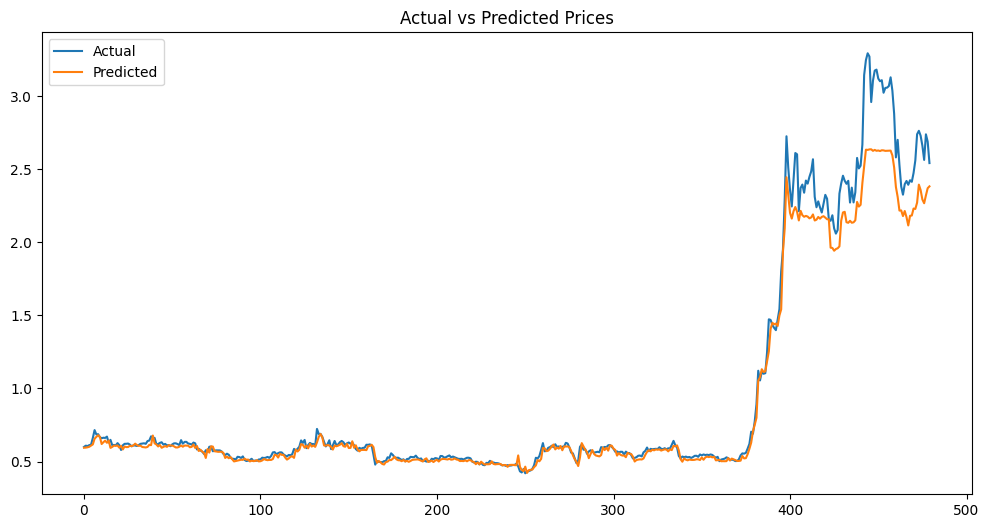

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = 3  # Assuming 'close' is the 4th column in price_cols
            pred_scaled = np.array(pred_scaled)  # Ensure numpy array
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.0001),
                      loss=tf.keras.losses.Huber(delta=1.4),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=80):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=10)],
                       batch_size=16,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=15, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=50):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=16,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json"
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        base_preds = [cnn_rnn_preds, xgb_preds, xgb_preds, naive_forecast, naive_forecast, naive_forecast, cnn_rnn_all_data_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                seq_scaled[0, -1, 3],
                seq_scaled[0, -1, 3],
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            base_preds_list = []
            for i in base_preds:
                base_preds_list.append(self.pipeline.inverse_transform_predictions([i], 'close')[0])
            return final_pred, base_preds_list
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((7,)),  # Now expects 5 inputs
        'xgb': SimpleXGBoost()
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()

In [78]:
predicted_close, baseline_preds = ensemble.predict_next_day(new_data_2)
print("Predicted next day close price:", predicted_close)

Predicted next day close price: 2.4346917337727545


In [79]:
baseline_preds

[np.float64(1.0839128192609548),
 np.float64(2.1909892431259155),
 np.float64(2.1909892431259155),
 np.float64(2.2827),
 np.float64(2.2827),
 np.float64(2.2827),
 np.float64(2.7704832667517665)]

Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Training base CNN-RNN...
Epoch 1/50
120/120 - 11s - 88ms/step - loss: 0.2202 - mae: 0.4633 - mse: 0.5007 - val_loss: 1.2558 - val_mae: 1.1468 - val_mse: 5.7435
Epoch 2/50
120/120 - 2s - 17ms/step - loss: 0.1161 - mae: 0.3225 - mse: 0.2479 - val_loss: 1.0588 - val_mae: 0.9960 - val_mse: 4.4729
Epoch 3/50
120/120 - 2s - 18ms/step - loss: 0.0916 - mae: 0.2802 - mse: 0.1942 - val_loss: 0.9581 - val_mae: 0.9126 - val_mse: 3.8725
Epoch 4/50
120/120 - 2s - 18ms/step - loss: 0.0752 - mae: 0.2598 - mse: 0.1554 - val_loss: 0.9071 - val_mae: 0.8591 - val_mse: 3.6341
Epoch 5/50
120/120 - 2s - 17ms/step - loss: 0.0746 - mae: 0.2641 - mse: 0.1518 - val_loss: 0.9160 - val_mae: 0.8564 - val_mse: 3.6970
Epoch 6/50
120/120 - 2s - 20ms/step - loss: 0.0588 - mae: 0.2338 - mse: 0.1197 - val_loss: 0.8460 - val_mae: 0.8087 - val_mse: 3.2949
Epoch 7/50
120/120 - 2s - 19ms/step - loss: 0.0645 - mae: 0.2445 - mse: 0.1306 - val_loss: 0.9230 - val_mae: 0.8544 - val_mse: 3.8019
Epoch 8/50
120/120 - 2s - 19ms/step

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse
  current = self.get_monitor_value(logs)


150/150 - 1s - 9ms/step - loss: 0.0292 - mae: 0.1300 - mse: 0.0606
Epoch 3/50
150/150 - 1s - 9ms/step - loss: 0.0152 - mae: 0.0954 - mse: 0.0307
Epoch 4/50
150/150 - 1s - 9ms/step - loss: 0.0171 - mae: 0.0958 - mse: 0.0348
Epoch 5/50
150/150 - 1s - 8ms/step - loss: 0.0176 - mae: 0.0941 - mse: 0.0360
Epoch 6/50
150/150 - 1s - 9ms/step - loss: 0.0102 - mae: 0.0770 - mse: 0.0204
Epoch 7/50
150/150 - 1s - 8ms/step - loss: 0.0121 - mae: 0.0800 - mse: 0.0243
Epoch 8/50
150/150 - 1s - 8ms/step - loss: 0.0108 - mae: 0.0787 - mse: 0.0217
Epoch 9/50
150/150 - 1s - 8ms/step - loss: 0.0091 - mae: 0.0722 - mse: 0.0182
Epoch 10/50
150/150 - 1s - 8ms/step - loss: 0.0152 - mae: 0.0854 - mse: 0.0308
Epoch 11/50
150/150 - 1s - 8ms/step - loss: 0.0088 - mae: 0.0696 - mse: 0.0177
Epoch 12/50
150/150 - 1s - 8ms/step - loss: 0.0153 - mae: 0.0851 - mse: 0.0317
Epoch 13/50
150/150 - 1s - 8ms/step - loss: 0.0103 - mae: 0.0739 - mse: 0.0209
Epoch 14/50
150/150 - 1s - 8ms/step - loss: 0.0073 - mae: 0.0652 - mse:

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


120/120 - 0s - 3ms/step - loss: 0.0033 - mae: 0.0469 - mse: 0.0065 - learning_rate: 8.0000e-04
Epoch 3/50
120/120 - 0s - 3ms/step - loss: 0.0026 - mae: 0.0416 - mse: 0.0053 - learning_rate: 8.0000e-04
Epoch 4/50
120/120 - 0s - 2ms/step - loss: 0.0014 - mae: 0.0318 - mse: 0.0027 - learning_rate: 8.0000e-04
Epoch 5/50
120/120 - 0s - 2ms/step - loss: 0.0012 - mae: 0.0313 - mse: 0.0024 - learning_rate: 8.0000e-04
Epoch 6/50
120/120 - 0s - 3ms/step - loss: 0.0011 - mae: 0.0291 - mse: 0.0021 - learning_rate: 8.0000e-04
Epoch 7/50
120/120 - 0s - 2ms/step - loss: 0.0016 - mae: 0.0341 - mse: 0.0031 - learning_rate: 8.0000e-04
Epoch 8/50
120/120 - 0s - 3ms/step - loss: 0.0012 - mae: 0.0306 - mse: 0.0023 - learning_rate: 8.0000e-04
Epoch 9/50
120/120 - 0s - 3ms/step - loss: 0.0014 - mae: 0.0320 - mse: 0.0027 - learning_rate: 8.0000e-04
Epoch 10/50
120/120 - 0s - 3ms/step - loss: 0.0012 - mae: 0.0301 - mse: 0.0024 - learning_rate: 8.0000e-04
Epoch 11/50
120/120 - 0s - 3ms/step - loss: 0.0012 - mae

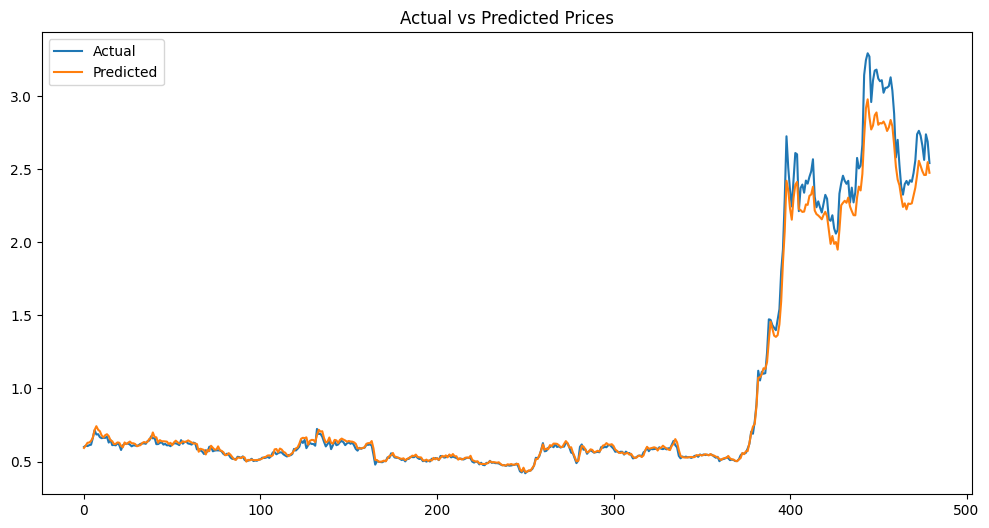

In [87]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = self.price_cols.index('close')
            pred_scaled = np.array(pred_scaled)
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== New Deep Neural Network Model ======================
class DeepNN:
    """
    A very deep neural network that treats the input as flattened (non-time series) data.
    """
    def __init__(self, input_shape):
        # input_shape is (seq_length, num_features); flatten it.
        self.input_dim = input_shape[0] * input_shape[1]
        self.model = self._build_model(self.input_dim)

    def _build_model(self, input_dim):
        model = Sequential([
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.00008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data=None, epochs=50):
        # Flatten the input sequences
        X_flat = X_train.reshape(X_train.shape[0], -1)
        if validation_data:
            X_val, y_val = validation_data
            X_val_flat = X_val.reshape(X_val.shape[0], -1)
            self.model.fit(X_flat, y_train, validation_data=(X_val_flat, y_val),
                           epochs=epochs, batch_size=16, callbacks=[EarlyStopping(patience=5)], verbose=2)
        else:
            self.model.fit(X_flat, y_train, epochs=epochs, batch_size=16,
                           callbacks=[EarlyStopping(patience=5)], verbose=2)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

# ====================== Other Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.0001),
                      loss=tf.keras.losses.Huber(delta=1.4),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=50):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=10)],
                       batch_size=16,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=15, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=50):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=16,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        # Expect models dict to include keys: 'cnn_rnn', 'cnn_rnn_all_data', 'xgb', 'deep_nn', 'deep_nn_all_data', 'meta'
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'deep_nn': type('', (), {'model': None}),
            'deep_nn_all_data': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        # We do not save the deep NN models here; if needed, they can be saved separately.\n        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:\n            pickle.dump(self.pipeline, f)\n        print(f\"Models and pipeline saved to {self.model_dir}\")"

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json"
            # Deep NN models are not loaded here; they must be retrained or saved separately if needed.
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining deep NN (train-val split)...")
        self.models['deep_nn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining deep NN (all data)...")
        self.models['deep_nn_all_data'].train(X_all, y_all)
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        deep_nn_preds = self.models['deep_nn'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        deep_nn_all_data_preds = self.models['deep_nn_all_data'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, cnn_rnn_all_data_preds, deep_nn_preds, deep_nn_all_data_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                self.models['deep_nn'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['deep_nn_all_data'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            base_preds_list = []
            for i in base_preds:
                base_preds_list.append(self.pipeline.inverse_transform_predictions([i], 'close')[0])
            return final_pred, base_preds_list
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['deep_nn'].train(X_all, y_all)
        self.models['deep_nn_all_data'].train(X_all, y_all)

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((6,)),  # Meta-model now expects 6 inputs (from 6 base predictions)
        'xgb': SimpleXGBoost(),
        'deep_nn': DeepNN(input_shape),
        'deep_nn_all_data': DeepNN(input_shape)
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # To predict a new day's close price, prepare a DataFrame 'new_data' with the same features.
    # Example:
    # predicted_close, base_preds = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Predicted')
    plt.title("Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('predviz.jpeg')
    plt.show()


In [88]:
predicted_close, baseline_preds = ensemble.predict_next_day(new_data_2)
print("Predicted next day close price:", predicted_close)

Predicted next day close price: 2.508225466195345


In [89]:
baseline_preds

[np.float64(1.1261126398807764),
 np.float64(2.1909892431259155),
 np.float64(2.2827),
 np.float64(2.206238099204302),
 np.float64(2.4234513245368006),
 np.float64(2.7546206105935576)]

Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Training base CNN-RNN...
Epoch 1/50
120/120 - 18s - 153ms/step - loss: 0.1654 - mae: 0.3914 - mse: 0.3681 - val_loss: 1.1630 - val_mae: 1.0980 - val_mse: 5.0773
Epoch 2/50
120/120 - 3s - 22ms/step - loss: 0.1049 - mae: 0.3124 - mse: 0.2250 - val_loss: 1.1345 - val_mae: 1.0426 - val_mse: 5.0552
Epoch 3/50
120/120 - 3s - 22ms/step - loss: 0.0876 - mae: 0.2781 - mse: 0.1821 - val_loss: 0.9974 - val_mae: 0.9592 - val_mse: 4.1580
Epoch 4/50
120/120 - 2s - 19ms/step - loss: 0.0790 - mae: 0.2647 - mse: 0.1662 - val_loss: 1.0469 - val_mae: 0.9462 - val_mse: 4.5596
Epoch 5/50
120/120 - 2s - 20ms/step - loss: 0.0687 - mae: 0.2549 - mse: 0.1404 - val_loss: 0.9658 - val_mae: 0.8954 - val_mse: 4.0654
Epoch 6/50
120/120 - 2s - 19ms/step - loss: 0.0623 - mae: 0.2373 - mse: 0.1259 - val_loss: 0.9529 - val_mae: 0.8724 - val_mse: 3.9658
Epoch 7/50
120/120 - 2s - 20ms/step - loss: 0.0614 - mae: 0.2421 - mse: 0.1256 - val_loss: 0.9714 - val_mae: 0.8851 - val_mse: 4.0851
Epoch 8/50
120/120 - 2s - 19ms/ste

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse
  current = self.get_monitor_value(logs)


150/150 - 1s - 9ms/step - loss: 0.0256 - mae: 0.1209 - mse: 0.0535
Epoch 3/50
150/150 - 1s - 9ms/step - loss: 0.0207 - mae: 0.1093 - mse: 0.0418
Epoch 4/50
150/150 - 1s - 9ms/step - loss: 0.0213 - mae: 0.1063 - mse: 0.0439
Epoch 5/50
150/150 - 1s - 9ms/step - loss: 0.0117 - mae: 0.0849 - mse: 0.0235
Epoch 6/50
150/150 - 1s - 9ms/step - loss: 0.0129 - mae: 0.0869 - mse: 0.0258
Epoch 7/50
150/150 - 1s - 9ms/step - loss: 0.0090 - mae: 0.0771 - mse: 0.0180
Epoch 8/50
150/150 - 1s - 9ms/step - loss: 0.0149 - mae: 0.0879 - mse: 0.0301
Epoch 9/50
150/150 - 1s - 9ms/step - loss: 0.0094 - mae: 0.0742 - mse: 0.0188
Epoch 10/50
150/150 - 1s - 9ms/step - loss: 0.0074 - mae: 0.0678 - mse: 0.0149
Epoch 11/50
150/150 - 1s - 9ms/step - loss: 0.0136 - mae: 0.0798 - mse: 0.0279
Epoch 12/50
150/150 - 1s - 9ms/step - loss: 0.0133 - mae: 0.0784 - mse: 0.0267
Epoch 13/50
150/150 - 1s - 9ms/step - loss: 0.0068 - mae: 0.0636 - mse: 0.0137
Epoch 14/50
150/150 - 1s - 9ms/step - loss: 0.0086 - mae: 0.0689 - mse:

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse,learning_rate.
  callback.on_epoch_end(epoch, logs)


120/120 - 0s - 4ms/step - loss: 0.0030 - mae: 0.0456 - mse: 0.0060 - learning_rate: 8.0000e-04
Epoch 3/50
120/120 - 0s - 3ms/step - loss: 0.0023 - mae: 0.0419 - mse: 0.0047 - learning_rate: 8.0000e-04
Epoch 4/50
120/120 - 0s - 3ms/step - loss: 0.0016 - mae: 0.0364 - mse: 0.0033 - learning_rate: 8.0000e-04
Epoch 5/50
120/120 - 0s - 3ms/step - loss: 0.0015 - mae: 0.0345 - mse: 0.0030 - learning_rate: 8.0000e-04
Epoch 6/50
120/120 - 0s - 3ms/step - loss: 0.0015 - mae: 0.0338 - mse: 0.0030 - learning_rate: 8.0000e-04
Epoch 7/50
120/120 - 0s - 3ms/step - loss: 0.0014 - mae: 0.0335 - mse: 0.0029 - learning_rate: 8.0000e-04
Epoch 8/50
120/120 - 0s - 3ms/step - loss: 0.0017 - mae: 0.0354 - mse: 0.0034 - learning_rate: 8.0000e-04
Epoch 9/50
120/120 - 0s - 3ms/step - loss: 0.0018 - mae: 0.0384 - mse: 0.0037 - learning_rate: 8.0000e-04
Epoch 10/50
120/120 - 0s - 3ms/step - loss: 0.0014 - mae: 0.0337 - mse: 0.0028 - learning_rate: 8.0000e-04
Epoch 11/50
120/120 - 0s - 3ms/step - loss: 0.0014 - mae

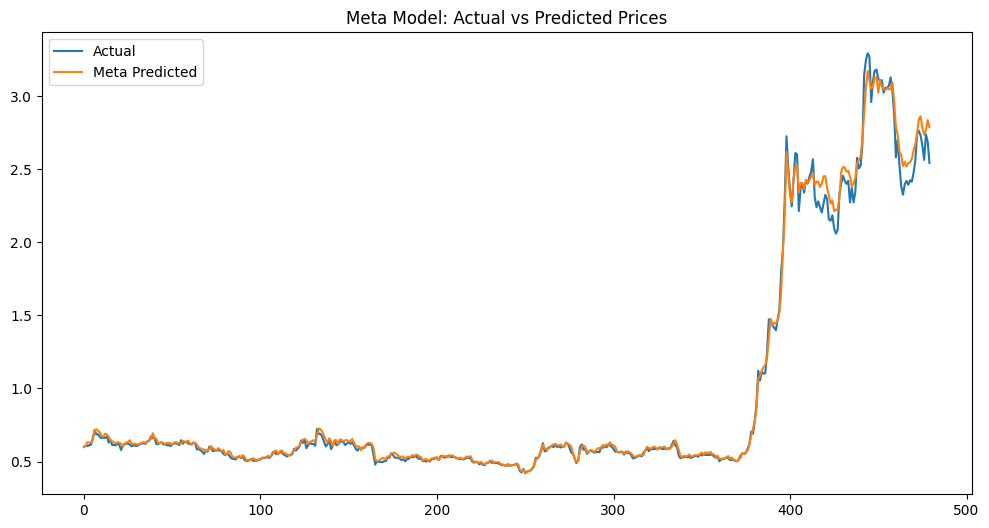

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Base Model Performance Metrics:
CNN_RNN - MAE: 0.2456, RMSE: 0.5555, MAPE: 12.45%
CNN_RNN_All_Data - MAE: 0.0804, RMSE: 0.1517, MAPE: 6.25%
XGB - MAE: 0.0938, RMSE: 0.1949, MAPE: 5.50%
Naive_Forecast - MAE: 0.0309, RMSE: 0.0654, MAPE: 2.71%
DeepNN - MAE: 0.0606, RMSE: 0.1248, MAPE: 4.45%
DeepNN_All_Data - MAE: 0.0239, RMSE: 0.0477, MAPE: 1.87%


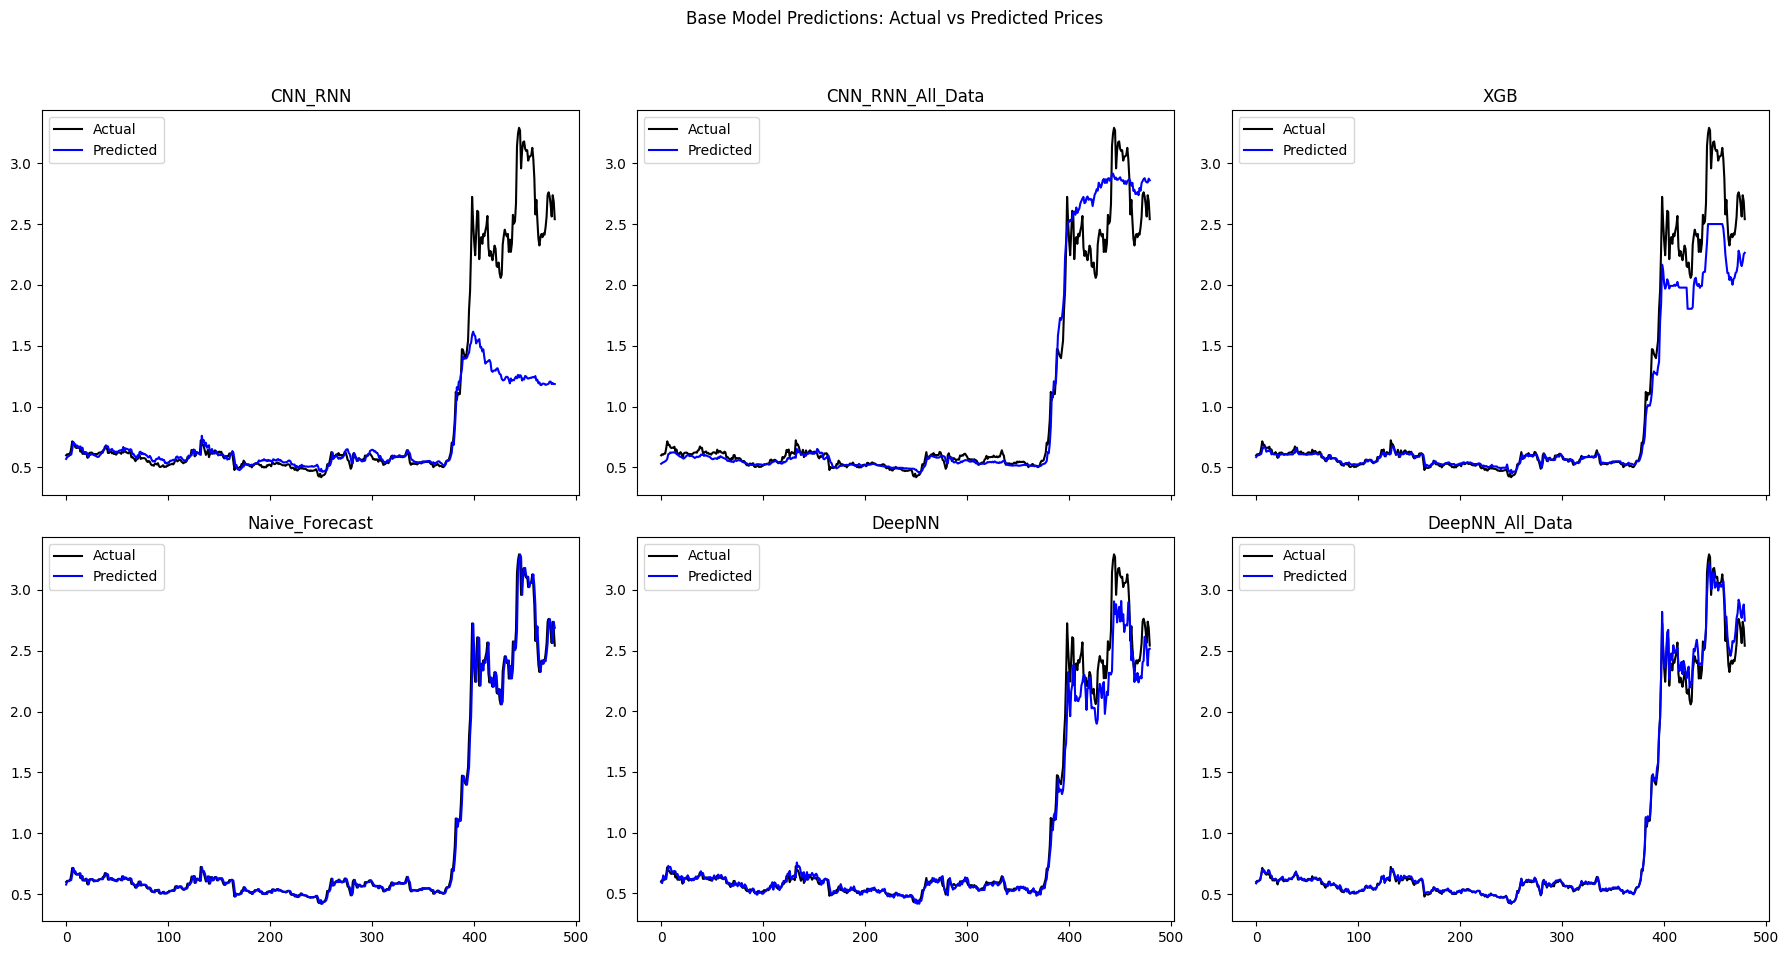

In [93]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = self.price_cols.index('close')
            pred_scaled = np.array(pred_scaled)
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== New Deep Neural Network Model ======================
class DeepNN:
    """
    A very deep neural network that treats the input as flattened (non-time series) data.
    """
    def __init__(self, input_shape):
        # input_shape is (seq_length, num_features); flatten it.
        self.input_dim = input_shape[0] * input_shape[1]
        self.model = self._build_model(self.input_dim)

    def _build_model(self, input_dim):
        model = Sequential([
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.00008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data=None, epochs=50):
        # Flatten the input sequences
        X_flat = X_train.reshape(X_train.shape[0], -1)
        if validation_data:
            X_val, y_val = validation_data
            X_val_flat = X_val.reshape(X_val.shape[0], -1)
            self.model.fit(X_flat, y_train, validation_data=(X_val_flat, y_val),
                           epochs=epochs, batch_size=16, callbacks=[EarlyStopping(patience=5)], verbose=2)
        else:
            self.model.fit(X_flat, y_train, epochs=epochs, batch_size=16,
                           callbacks=[EarlyStopping(patience=5)], verbose=2)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

# ====================== Other Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.0001),
                      loss=tf.keras.losses.Huber(delta=1.4),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=50):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=10)],
                       batch_size=16,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=15, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=50):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=16,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        # Expect models dict to include keys: 'cnn_rnn', 'cnn_rnn_all_data', 'xgb', 'deep_nn', 'deep_nn_all_data', 'meta'
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'deep_nn': type('', (), {'model': None}),
            'deep_nn_all_data': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        # We do not save deep NN models here; if needed, they can be saved separately.
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json"
            # Deep NN models are not loaded here; they must be retrained or saved separately if needed.
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining deep NN (train-val split)...")
        self.models['deep_nn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining deep NN (all data)...")
        self.models['deep_nn_all_data'].train(X_all, y_all)
        meta_X_train = self._prepare_meta_input(X_train, X_all, y_train)
        print("\nTraining Meta Model...")
        self.models['meta'].train(meta_X_train, y_train)

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        deep_nn_preds = self.models['deep_nn'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        deep_nn_all_data_preds = self.models['deep_nn_all_data'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, cnn_rnn_all_data_preds, deep_nn_preds, deep_nn_all_data_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                self.models['deep_nn'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['deep_nn_all_data'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            base_preds_list = []
            for i in base_preds:
                base_preds_list.append(self.pipeline.inverse_transform_predictions([i], 'close')[0])
            return final_pred, base_preds_list
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['deep_nn'].train(X_all, y_all)
        self.models['deep_nn_all_data'].train(X_all, y_all)

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((6,)),  # Meta-model expects 6 inputs (from 6 base predictions)
        'xgb': SimpleXGBoost(),
        'deep_nn': DeepNN(input_shape),
        'deep_nn_all_data': DeepNN(input_shape)
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # Evaluate meta-model performance
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    metrics = {
        'Meta MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'Meta RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'Meta MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Meta Model Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Meta Predicted')
    plt.title("Meta Model: Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('meta_predviz.jpeg')
    plt.show()
    
    # ------------------------- Evaluate Base Models -------------------------
    # Obtain individual predictions for each base model on X_test:
    cnn_rnn_preds_scaled = ensemble.models['cnn_rnn'].model.predict(X_test).flatten()
    cnn_rnn_all_data_preds_scaled = ensemble.models['cnn_rnn_all_data'].model.predict(X_test).flatten()
    xgb_preds_scaled = ensemble.models['xgb'].predict(X_test)
    naive_forecast_scaled = np.array([x[-1, 3] for x in X_test])
    deep_nn_preds_scaled = ensemble.models['deep_nn'].model.predict(X_test.reshape(X_test.shape[0], -1)).flatten()
    deep_nn_all_data_preds_scaled = ensemble.models['deep_nn_all_data'].model.predict(X_test.reshape(X_test.shape[0], -1)).flatten()
    
    # Inverse transform all predictions (assuming they are in the scaled domain)
    cnn_rnn_preds = pipeline.inverse_transform_predictions(cnn_rnn_preds_scaled, 'close')
    cnn_rnn_all_data_preds = pipeline.inverse_transform_predictions(cnn_rnn_all_data_preds_scaled, 'close')
    xgb_preds = pipeline.inverse_transform_predictions(xgb_preds_scaled, 'close')
    naive_forecast = pipeline.inverse_transform_predictions(naive_forecast_scaled, 'close')
    deep_nn_preds = pipeline.inverse_transform_predictions(deep_nn_preds_scaled, 'close')
    deep_nn_all_data_preds = pipeline.inverse_transform_predictions(deep_nn_all_data_preds_scaled, 'close')
    
    # Create a dictionary of predictions and names for ease of iteration:
    base_model_preds = {
        'CNN_RNN': cnn_rnn_preds,
        'CNN_RNN_All_Data': cnn_rnn_all_data_preds,
        'XGB': xgb_preds,
        'Naive_Forecast': naive_forecast,
        'DeepNN': deep_nn_preds,
        'DeepNN_All_Data': deep_nn_all_data_preds
    }
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    print("\nBase Model Performance Metrics:")
    for name, preds in base_model_preds.items():
        mae = mean_absolute_error(y_test_unscaled, preds)
        rmse = np.sqrt(mean_squared_error(y_test_unscaled, preds))
        mape = np.mean(np.abs((y_test_unscaled - preds)/y_test_unscaled)) * 100
        print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    
    # Plot predictions for each base model in subplots
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
    axs = axs.flatten()
    for i, (name, preds) in enumerate(base_model_preds.items()):
        axs[i].plot(y_test_unscaled, label='Actual', color='black')
        axs[i].plot(preds, label='Predicted', color='blue')
        axs[i].set_title(f"{name}")
        axs[i].legend()
    plt.suptitle("Base Model Predictions: Actual vs Predicted Prices")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('base_models_predviz.jpeg')
    plt.show()


In [94]:
predicted_close, baseline_preds = ensemble.predict_next_day(new_data_2)
print("Predicted next day close price:", predicted_close)

Predicted next day close price: 2.854154073653221


In [95]:
baseline_preds

[np.float64(1.1306169411838054),
 np.float64(2.1909892431259155),
 np.float64(2.2827),
 np.float64(2.1183381501054765),
 np.float64(2.452735922329426),
 np.float64(2.793969853887558)]

Starting data preprocessing...
Data preprocessing finished. Training samples: 1918, Test samples: 480


c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Training base CNN-RNN...
Epoch 1/50
120/120 - 10s - 81ms/step - loss: 0.1610 - mae: 0.3885 - mse: 0.3763 - val_loss: 1.1128 - val_mae: 1.0831 - val_mse: 5.1858
Epoch 2/50
120/120 - 2s - 19ms/step - loss: 0.0855 - mae: 0.2676 - mse: 0.1836 - val_loss: 0.9811 - val_mae: 0.9622 - val_mse: 4.3258
Epoch 3/50
120/120 - 2s - 16ms/step - loss: 0.0594 - mae: 0.2295 - mse: 0.1225 - val_loss: 0.9267 - val_mae: 0.9109 - val_mse: 4.0201
Epoch 4/50
120/120 - 2s - 16ms/step - loss: 0.0533 - mae: 0.2149 - mse: 0.1098 - val_loss: 0.9130 - val_mae: 0.9024 - val_mse: 3.9494
Epoch 5/50
120/120 - 2s - 16ms/step - loss: 0.0450 - mae: 0.2041 - mse: 0.0919 - val_loss: 0.9144 - val_mae: 0.9112 - val_mse: 3.9714
Epoch 6/50
120/120 - 2s - 16ms/step - loss: 0.0438 - mae: 0.2010 - mse: 0.0886 - val_loss: 0.8928 - val_mae: 0.8824 - val_mse: 3.8465
Epoch 7/50
120/120 - 2s - 16ms/step - loss: 0.0391 - mae: 0.1903 - mse: 0.0799 - val_loss: 0.8604 - val_mae: 0.8580 - val_mse: 3.6271
Epoch 8/50
120/120 - 2s - 16ms/step

c:\Users\chidi\Documents\timeseries_projects\tvenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse
  current = self.get_monitor_value(logs)


150/150 - 1s - 7ms/step - loss: 0.0395 - mae: 0.1431 - mse: 0.0843
Epoch 3/50
150/150 - 1s - 7ms/step - loss: 0.0217 - mae: 0.1080 - mse: 0.0444
Epoch 4/50
150/150 - 1s - 8ms/step - loss: 0.0164 - mae: 0.0953 - mse: 0.0333
Epoch 5/50
150/150 - 1s - 8ms/step - loss: 0.0145 - mae: 0.0898 - mse: 0.0293
Epoch 6/50
150/150 - 1s - 7ms/step - loss: 0.0111 - mae: 0.0806 - mse: 0.0224
Epoch 7/50
150/150 - 1s - 7ms/step - loss: 0.0093 - mae: 0.0750 - mse: 0.0186
Epoch 8/50
150/150 - 1s - 9ms/step - loss: 0.0086 - mae: 0.0721 - mse: 0.0172
Epoch 9/50
150/150 - 1s - 8ms/step - loss: 0.0078 - mae: 0.0690 - mse: 0.0155
Epoch 10/50
150/150 - 1s - 7ms/step - loss: 0.0068 - mae: 0.0645 - mse: 0.0136
Epoch 11/50
150/150 - 1s - 7ms/step - loss: 0.0061 - mae: 0.0620 - mse: 0.0122
Epoch 12/50
150/150 - 1s - 7ms/step - loss: 0.0055 - mae: 0.0601 - mse: 0.0111
Epoch 13/50
150/150 - 1s - 7ms/step - loss: 0.0053 - mae: 0.0587 - mse: 0.0107
Epoch 14/50
150/150 - 1s - 8ms/step - loss: 0.0051 - mae: 0.0575 - mse:

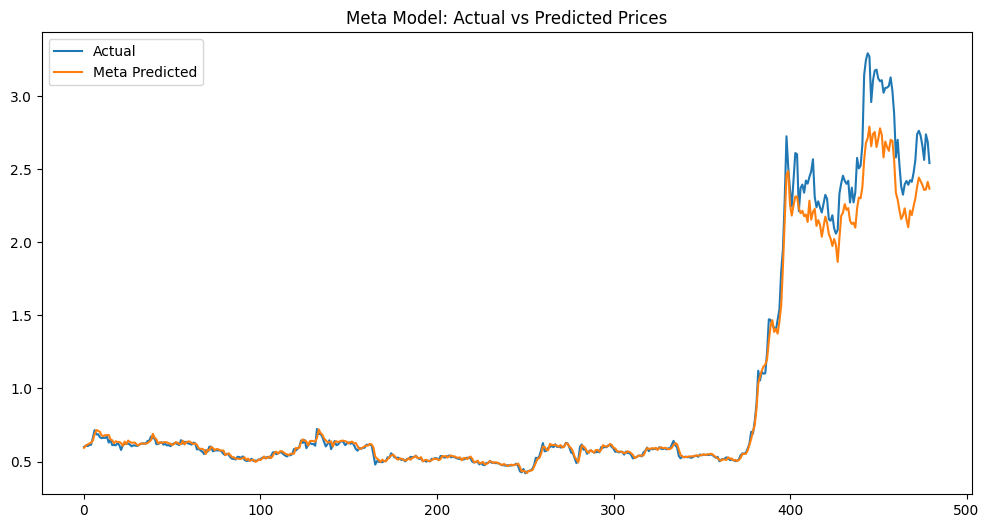

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Base Model Performance Metrics:
CNN_RNN - MAE: 0.2627, RMSE: 0.5776, MAPE: 13.97%
CNN_RNN_All_Data - MAE: 0.0689, RMSE: 0.1242, MAPE: 6.07%
XGB - MAE: 0.0938, RMSE: 0.1949, MAPE: 5.50%
Naive_Forecast - MAE: 0.0309, RMSE: 0.0654, MAPE: 2.71%
DeepNN - MAE: 0.0642, RMSE: 0.1191, MAPE: 5.63%
DeepNN_All_Data - MAE: 0.0488, RMSE: 0.1037, MAPE: 3.25%


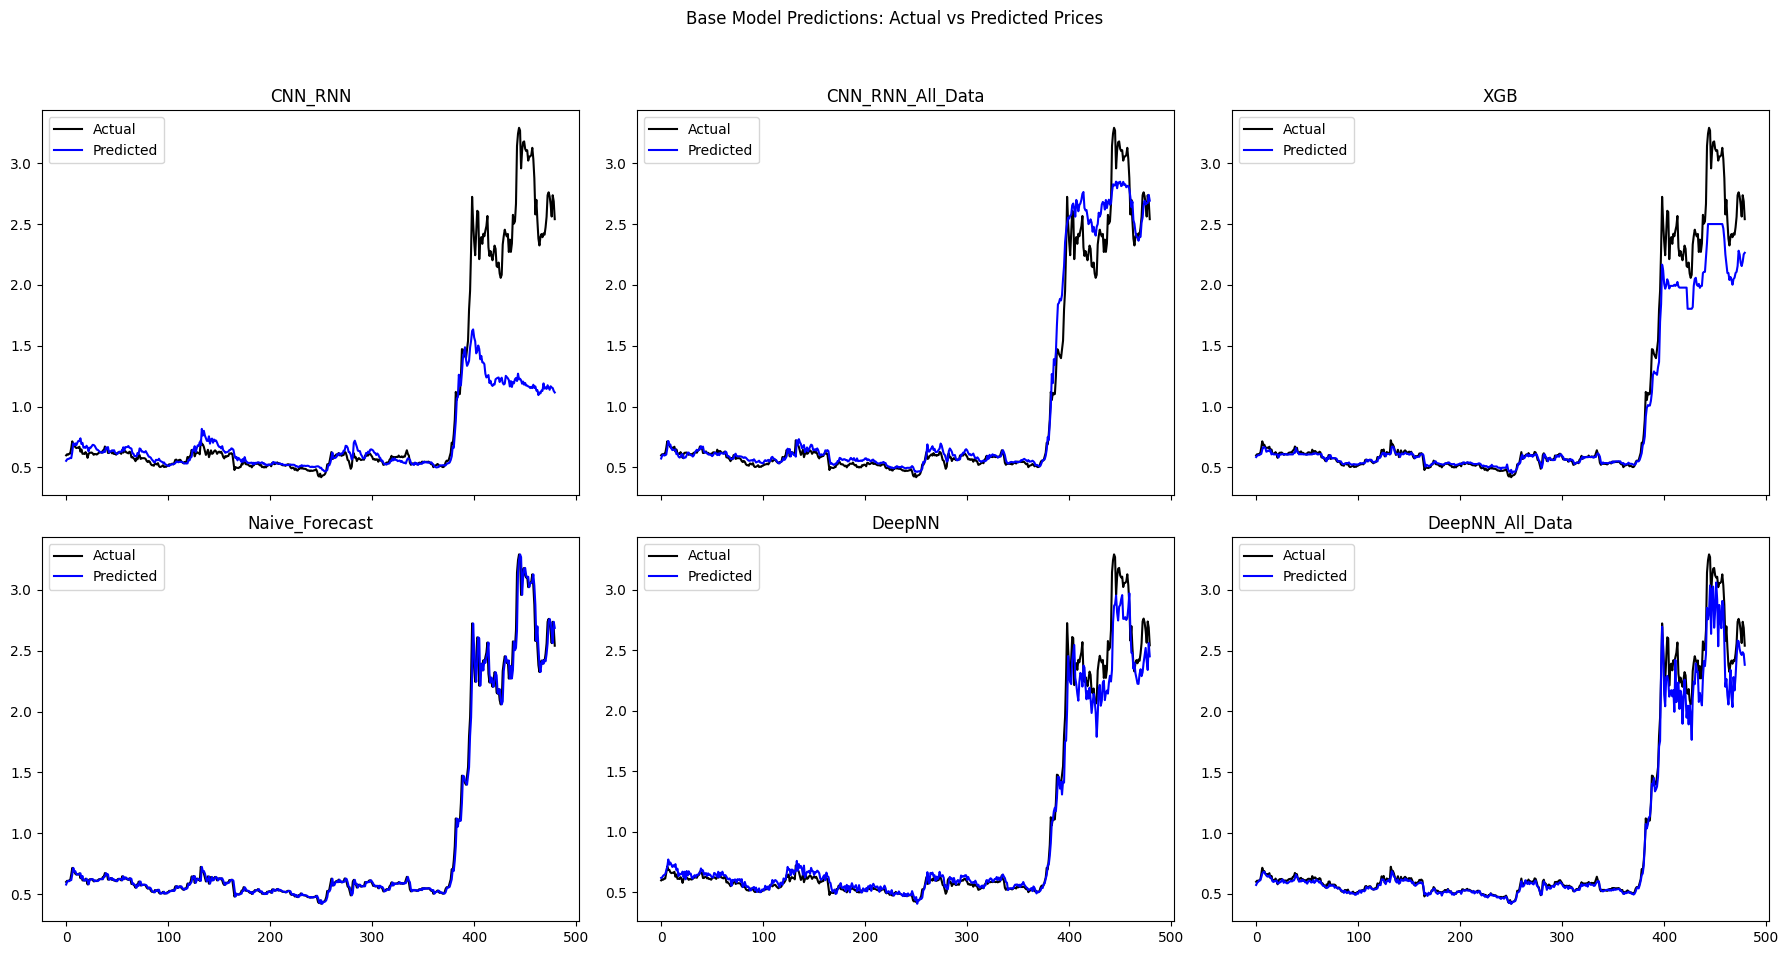

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import random

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)


# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = self.price_cols.index('close')
            pred_scaled = np.array(pred_scaled)
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== New Deep Neural Network Model ======================
class DeepNN:
    """
    A very deep neural network that treats the input as flattened (non-time series) data.
    """
    def __init__(self, input_shape):
        # input_shape is (seq_length, num_features); flatten it.
        self.input_dim = input_shape[0] * input_shape[1]
        self.model = self._build_model(self.input_dim)

    def _build_model(self, input_dim):
        model = Sequential([
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.00005),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data=None, epochs=50):
        # Flatten the input sequences
        X_flat = X_train.reshape(X_train.shape[0], -1)
        if validation_data:
            X_val, y_val = validation_data
            X_val_flat = X_val.reshape(X_val.shape[0], -1)
            self.model.fit(X_flat, y_train, validation_data=(X_val_flat, y_val),
                           epochs=epochs, batch_size=16, callbacks=[EarlyStopping(patience=5)], verbose=2)
        else:
            self.model.fit(X_flat, y_train, epochs=epochs, batch_size=16,
                           callbacks=[EarlyStopping(patience=5)], verbose=2)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

# ====================== Other Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.2)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.0001),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=50):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=10)],
                       batch_size=16,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=15, learning_rate=0.1)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.00005),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=50, validation_data=None):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=16,
                       validation_data=validation_data,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        # Expect models dict to include keys: 'cnn_rnn', 'cnn_rnn_all_data', 'xgb', 'deep_nn', 'deep_nn_all_data', 'meta'
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'deep_nn': type('', (), {'model': None}),
            'deep_nn_all_data': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        # We do not save deep NN models here; if needed, they can be saved separately.
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json"
            # Deep NN models are not loaded here; they must be retrained or saved separately if needed.
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining deep NN (train-val split)...")
        self.models['deep_nn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining deep NN (all data)...")
        self.models['deep_nn_all_data'].train(X_all, y_all)
        
        # Prepare meta input from the training set
        meta_X = self._prepare_meta_input(X_train, X_all, y_train)
        # Split meta input into train and validation (80:20)
        meta_X_train, meta_X_val, meta_y_train, meta_y_val = train_test_split(meta_X, y_train, test_size=0.2, random_state=42)
        print("\nTraining Meta Model with 80:20 split...")
        self.models['meta'].train(meta_X_train, meta_y_train, validation_data=(meta_X_val, meta_y_val))

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        deep_nn_preds = self.models['deep_nn'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        deep_nn_all_data_preds = self.models['deep_nn_all_data'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, cnn_rnn_all_data_preds, deep_nn_preds, deep_nn_all_data_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                seq_scaled[0, -1, 3],
                self.models['deep_nn'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['deep_nn_all_data'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item()
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            base_preds_list = []
            for i in base_preds:
                base_preds_list.append(self.pipeline.inverse_transform_predictions([i], 'close')[0])
            return final_pred, base_preds_list
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['deep_nn'].train(X_all, y_all)
        self.models['deep_nn_all_data'].train(X_all, y_all)

# ====================== Main Execution ======================
if __name__ == "__main__":
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv')
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((6,)),  # Meta-model expects 6 inputs (from 6 base predictions)
        'xgb': SimpleXGBoost(),
        'deep_nn': DeepNN(input_shape),
        'deep_nn_all_data': DeepNN(input_shape)
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all)
    ensemble.save_models()
    
    # To predict a new day's close price, prepare a DataFrame 'new_data' with the same features.
    # Example:
    # predicted_close, base_preds = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    test_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_preds = pipeline.inverse_transform_predictions(test_preds.flatten(), 'close')
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    metrics = {
        'Meta MAE': mean_absolute_error(y_test_unscaled, final_preds),
        'Meta RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_preds)),
        'Meta MAPE': np.mean(np.abs((y_test_unscaled - final_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Meta Model Performance Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_preds, label='Meta Predicted')
    plt.title("Meta Model: Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('meta_predviz.jpeg')
    plt.show()
    
    # ------------------------- Evaluate Base Models -------------------------
    cnn_rnn_preds_scaled = ensemble.models['cnn_rnn'].model.predict(X_test).flatten()
    cnn_rnn_all_data_preds_scaled = ensemble.models['cnn_rnn_all_data'].model.predict(X_test).flatten()
    xgb_preds_scaled = ensemble.models['xgb'].predict(X_test)
    naive_forecast_scaled = np.array([x[-1, 3] for x in X_test])
    deep_nn_preds_scaled = ensemble.models['deep_nn'].model.predict(X_test.reshape(X_test.shape[0], -1)).flatten()
    deep_nn_all_data_preds_scaled = ensemble.models['deep_nn_all_data'].model.predict(X_test.reshape(X_test.shape[0], -1)).flatten()
    
    cnn_rnn_preds = pipeline.inverse_transform_predictions(cnn_rnn_preds_scaled, 'close')
    cnn_rnn_all_data_preds = pipeline.inverse_transform_predictions(cnn_rnn_all_data_preds_scaled, 'close')
    xgb_preds = pipeline.inverse_transform_predictions(xgb_preds_scaled, 'close')
    naive_forecast = pipeline.inverse_transform_predictions(naive_forecast_scaled, 'close')
    deep_nn_preds = pipeline.inverse_transform_predictions(deep_nn_preds_scaled, 'close')
    deep_nn_all_data_preds = pipeline.inverse_transform_predictions(deep_nn_all_data_preds_scaled, 'close')
    
    base_model_preds = {
        'CNN_RNN': cnn_rnn_preds,
        'CNN_RNN_All_Data': cnn_rnn_all_data_preds,
        'XGB': xgb_preds,
        'Naive_Forecast': naive_forecast,
        'DeepNN': deep_nn_preds,
        'DeepNN_All_Data': deep_nn_all_data_preds
    }
    
    print("\nBase Model Performance Metrics:")
    for name, preds in base_model_preds.items():
        mae = mean_absolute_error(y_test_unscaled, preds)
        rmse = np.sqrt(mean_squared_error(y_test_unscaled, preds))
        mape = np.mean(np.abs((y_test_unscaled - preds)/y_test_unscaled)) * 100
        print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    
    fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
    axs = axs.flatten()
    for i, (name, preds) in enumerate(base_model_preds.items()):
        axs[i].plot(y_test_unscaled, label='Actual', color='black')
        axs[i].plot(preds, label='Predicted', color='blue')
        axs[i].set_title(f"{name}")
        axs[i].legend()
    plt.suptitle("Base Model Predictions: Actual vs Predicted Prices")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('base_models_predviz.jpeg')
    plt.show()


In [6]:
predicted_close, baseline_preds = ensemble.predict_next_day(new_data_2)
print("Predicted next day close price:", predicted_close)

Predicted next day close price: 2.2841137358009815


In [7]:
baseline_preds

[np.float64(1.115121400529146),
 np.float64(2.1909892431259155),
 np.float64(2.2827),
 np.float64(2.1726392906701566),
 np.float64(2.141208806897402),
 np.float64(2.46859105155468)]

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, LSTM, Conv1D, 
                                     Bidirectional, Dropout, BatchNormalization, Input, Flatten)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import os

# Set seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# ------------------ Prophet Model ------------------
# Use the new 'prophet' package (if using older version, use fbprophet)
from prophet import Prophet

class ProphetModel:
    """
    A wrapper for Facebook Prophet. It trains on a DataFrame containing
    'ds' (datetime) and 'y' (close price) and forecasts the next period.
    """
    def __init__(self):
        self.model = Prophet(daily_seasonality=True)
        self.fitted = False

    def train(self, df):
        # df must have columns 'ds' and 'y'
        self.model.fit(df)
        self.fitted = True

    def predict(self, periods=1):
        if not self.fitted:
            raise ValueError("Prophet model not trained.")
        future = self.model.make_future_dataframe(periods=periods, freq='D')
        forecast = self.model.predict(future)
        return forecast['yhat'].iloc[-1]

# ====================== Data Preprocessing ======================
class TimeSeriesPipeline:
    def __init__(self, seq_length=30, test_size=0.2):
        self.seq_length = seq_length
        self.test_size = test_size
        self.scalers = {}
        self.price_cols = ['open', 'high', 'low', 'close', 'av_pr', 'diff', '7_day_SMA', 
                           '30_day_SMA', '7_day_EMA', '30_day_EMA', '12_day_EMA', '26_day_EMA', '20_day_SMA']
        self.volatility_cols = ['20_day_STD', 'Upper_Band', 'Lower_Band']
        self.momentum_cols = ['RSI', 'MACD', 'Signal_Line']
        self.lag_cols = ['lag_1', 'lag_2', 'lag_3']

    def preprocess_data(self, df, fit_scalers=True, save_scalers=True, scalers_path="scalers.pkl"):
        print("Starting data preprocessing...")
        unscaled_data = df.copy()
        price_cols = self.price_cols
        volatility_cols = self.volatility_cols
        momentum_cols = self.momentum_cols
        lag_cols = self.lag_cols

        if not fit_scalers:
            with open(scalers_path, 'rb') as f:
                self.scalers = pickle.load(f)
        else:
            self._fit_scalers(df, price_cols, volatility_cols, momentum_cols, lag_cols)
            if save_scalers:
                with open(scalers_path, 'wb') as f:
                    pickle.dump(self.scalers, f)

        df_scaled = self._transform_features(df.copy(), price_cols, volatility_cols, momentum_cols, lag_cols)
        X_scaled, y_scaled = self.create_sequences(df_scaled)
        X_unscaled, y_unscaled = self.create_sequences(unscaled_data)
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = self.time_based_split(X_scaled, y_scaled)
        X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = self.time_based_split(X_unscaled, y_unscaled)
        print(f"Data preprocessing finished. Training samples: {len(X_train_scaled)}, Test samples: {len(X_test_scaled)}")
        return (X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled,
                X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled)

    def _fit_scalers(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        self.scalers = {
            'price': RobustScaler().fit(df[price_cols]),
            'volume': RobustScaler().fit(np.log1p(df[['volume']])),
            'volatility': StandardScaler().fit(df[volatility_cols]),
            'momentum': MinMaxScaler().fit(df[momentum_cols]),
            'lag': RobustScaler().fit(df[lag_cols])
        }

    def _transform_features(self, df, price_cols, volatility_cols, momentum_cols, lag_cols):
        df[price_cols] = self.scalers['price'].transform(df[price_cols])
        df['volume'] = self.scalers['volume'].transform(np.log1p(df[['volume']]))
        df[volatility_cols] = self.scalers['volatility'].transform(df[volatility_cols])
        df[momentum_cols] = self.scalers['momentum'].transform(df[momentum_cols])
        df[lag_cols] = self.scalers['lag'].transform(df[lag_cols])
        return df
    
    def transform_for_prediction(self, df):
        df_transformed = self._transform_features(df.copy(), 
                                                  self.price_cols,
                                                  self.volatility_cols,
                                                  self.momentum_cols,
                                                  self.lag_cols)
        if len(df_transformed) == self.seq_length:
            return np.array([df_transformed.values])
        elif len(df_transformed) > self.seq_length:
            X, _ = self.create_sequences(df_transformed)
            return X
        else:
            raise ValueError("Not enough data for a full sequence")
    
    def create_sequences(self, data):
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            seq = data.iloc[i:i+self.seq_length].values
            target = data.iloc[i+self.seq_length]['close']
            X.append(seq)
            y.append(target)
        return np.array(X), np.array(y)

    def time_based_split(self, X, y):
        split_idx = int(len(X) * (1 - self.test_size))
        return X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]

    def inverse_transform_predictions(self, pred_scaled, feature_name='close'):
        if feature_name == 'close':
            scaler = self.scalers['price']
            col_index = self.price_cols.index('close')
            pred_scaled = np.array(pred_scaled)
            return pred_scaled * scaler.scale_[col_index] + scaler.center_[col_index]
        raise ValueError(f"Unsupported feature for inversion: {feature_name}")

# ====================== New Deep Neural Network Model ======================
class DeepNN:
    """
    A very deep neural network that treats the input as flattened (non-time series) data.
    """
    def __init__(self, input_shape):
        self.input_dim = input_shape[0] * input_shape[1]
        self.model = self._build_model(self.input_dim)

    def _build_model(self, input_dim):
        model = Sequential([
            tf.keras.layers.InputLayer(input_shape=(input_dim,)),
            Dense(512, activation='relu'),
            Dense(512, activation='relu'),
            Dense(256, activation='relu'),
            Dense(256, activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.00008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data=None, epochs=50):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        if validation_data:
            X_val, y_val = validation_data
            X_val_flat = X_val.reshape(X_val.shape[0], -1)
            self.model.fit(X_flat, y_train, validation_data=(X_val_flat, y_val),
                           epochs=epochs, batch_size=16, callbacks=[EarlyStopping(patience=5)], verbose=2)
        else:
            self.model.fit(X_flat, y_train, epochs=epochs, batch_size=16,
                           callbacks=[EarlyStopping(patience=5)], verbose=2)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

# ====================== Other Model Definitions ======================
class HybridCNNRNN:
    def __init__(self, input_shape):
        if input_shape is None:
            raise ValueError("Input shape must be provided for HybridCNNRNN")
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, dilation_rate=2, activation='relu')(inputs)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Bidirectional(LSTM(32))(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(1)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(0.0001),
                      loss=tf.keras.losses.Huber(delta=1.4),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, validation_data, epochs=50):
        self.model.fit(X_train, y_train, 
                       validation_data=validation_data,
                       epochs=epochs,
                       callbacks=[EarlyStopping(patience=10)],
                       batch_size=16,
                       verbose=2)

class SimpleXGBoost:
    def __init__(self):
        self.model = XGBRegressor(n_estimators=15, learning_rate=0.1, seed=seed_value)

    def train(self, X_train, y_train):
        X_flat = X_train.reshape(X_train.shape[0], -1)
        self.model.fit(X_flat, y_train)

    def predict(self, X):
        X_flat = X.reshape(X.shape[0], -1)
        return self.model.predict(X_flat)

class MetaModel:
    def __init__(self, input_shape):
        self.model = self._build_model(input_shape)

    def _build_model(self, input_shape):
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer=Adam(0.0008),
                      loss=tf.keras.losses.Huber(delta=1.3),
                      metrics=['mae', 'mse'])
        return model

    def train(self, X_train, y_train, epochs=50, validation_data=None):
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=16,
                       validation_data=validation_data,
                       callbacks=[ReduceLROnPlateau(factor=0.5, patience=5)],
                       verbose=2)

# ====================== Prophet Model ======================
class ProphetModel:
    """
    A wrapper for Facebook Prophet. Expects a DataFrame with columns 'ds' (datetime)
    and 'y' (target close price) for training. It forecasts the next period.
    """
    def __init__(self):
        self.model = Prophet(daily_seasonality=True)
        self.fitted = False

    def train(self, df):
        # df must have columns 'ds' and 'y'
        self.model.fit(df)
        self.fitted = True

    def predict(self, periods=1):
        if not self.fitted:
            raise ValueError("Prophet model not trained.")
        future = self.model.make_future_dataframe(periods=periods, freq='D')
        forecast = self.model.predict(future)
        return forecast['yhat'].iloc[-1]

# ====================== Ensemble System ======================
class TemporalEnsemble:
    def __init__(self, pipeline, models):
        self.pipeline = pipeline
        # Expect models dict to include keys: 'cnn_rnn', 'cnn_rnn_all_data', 'xgb', 'deep_nn', 'deep_nn_all_data', 'prophet', 'meta'
        self.models = models if models else self._initialize_model_structure()
        self.full_data = None
        self.scalers_path = "scalers.pkl"
        self.model_dir = "saved_models"
        os.makedirs(self.model_dir, exist_ok=True)

    def _initialize_model_structure(self):
        return {
            'cnn_rnn': type('', (), {'model': None}),
            'cnn_rnn_all_data': type('', (), {'model': None}),
            'meta': type('', (), {'model': None}),
            'xgb': type('', (), {'model': None}),
            'deep_nn': type('', (), {'model': None}),
            'deep_nn_all_data': type('', (), {'model': None}),
            'prophet': type('', (), {'model': None})
        }

    def save_models(self):
        print("\nSaving models and pipeline...")
        self.models['cnn_rnn'].model.save(os.path.join(self.model_dir, "cnn_rnn_model.keras"))
        self.models['cnn_rnn_all_data'].model.save(os.path.join(self.model_dir, "cnn_rnn_all_data_model.keras"))
        self.models['meta'].model.save(os.path.join(self.model_dir, "meta_model.keras"))
        self.models['xgb'].model.save_model(os.path.join(self.model_dir, "xgb_model.json"))
        # Optionally, you can pickle Prophet model if needed
        with open(os.path.join(self.model_dir, "pipeline.pkl"), "wb") as f:
            pickle.dump(self.pipeline, f)
        print(f"Models and pipeline saved to {self.model_dir}")

    def load_models(self):
        print("\nLoading models and pipeline...")
        pipeline_path = os.path.join(self.model_dir, "pipeline.pkl")
        with open(pipeline_path, "rb") as f:
            self.pipeline = pickle.load(f)
        model_paths = {
            'cnn_rnn': "cnn_rnn_model.keras",
            'cnn_rnn_all_data': "cnn_rnn_all_data_model.keras",
            'meta': "meta_model.keras",
            'xgb': "xgb_model.json"
            # Deep NN and Prophet models are not loaded here; they must be retrained or saved separately if needed.
        }
        for model_key, filename in model_paths.items():
            path = os.path.join(self.model_dir, filename)
            if model_key == 'xgb':
                self.models[model_key].model = XGBRegressor()
                self.models[model_key].model.load_model(path)
            else:
                self.models[model_key].model = tf.keras.models.load_model(path)
        print("All models loaded successfully")

    def train_initial_models(self, X_train, y_train, X_val, y_val, X_all, y_all, df_original):
        print("\nTraining base CNN-RNN...")
        self.models['cnn_rnn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining XGBoost on all data...")
        self.models['xgb'].train(X_all, y_all)
        print("\nTraining full-data CNN-RNN...")
        self.models['cnn_rnn_all_data'].train(X_all, y_all, (X_all[:1], y_all[:1]))
        print("\nTraining deep NN (train-val split)...")
        self.models['deep_nn'].train(X_train, y_train, (X_val, y_val))
        print("\nTraining deep NN (all data)...")
        self.models['deep_nn_all_data'].train(X_all, y_all)
        print("\nTraining Prophet model on full data...")
        # Create Prophet training DataFrame from the original df
        # Assuming df_original has a 'datetime' column and 'close' column
        # Assuming 'df_original' is your DataFrame with datetime as the index
        df_prophet = df_original.reset_index()[['datetime', 'close']].copy()
        df_prophet.columns = ['ds', 'y']
        prophet_model = ProphetModel()
        prophet_model.train(df_prophet)
        self.models['prophet'].model = prophet_model  # store the ProphetModel instance
        # Prepare meta input from the training set and split 80:20
        meta_X = self._prepare_meta_input(X_train, X_all, y_train)
        meta_X_train, meta_X_val, meta_y_train, meta_y_val = train_test_split(meta_X, y_train, test_size=0.2, random_state=42)
        print("\nTraining Meta Model with 80:20 split...")
        self.models['meta'].train(meta_X_train, meta_y_train, validation_data=(meta_X_val, meta_y_val))

    def _prepare_meta_input(self, X_base, X_all, y_true):
        cnn_rnn_preds = self.models['cnn_rnn'].model.predict(X_base).flatten()
        xgb_preds = self.models['xgb'].predict(X_base)
        naive_forecast = np.array([x[-1, 3] for x in X_base])
        cnn_rnn_all_data_preds = self.models['cnn_rnn_all_data'].model.predict(X_base).flatten()
        deep_nn_preds = self.models['deep_nn'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        deep_nn_all_data_preds = self.models['deep_nn_all_data'].model.predict(X_base.reshape(X_base.shape[0], -1)).flatten()
        # Prophet prediction is global, so we call it once and replicate for each sample
        prophet_pred = self.models['prophet'].model.predict(periods=1)
        prophet_preds = np.full(shape=(X_base.shape[0],), fill_value=prophet_pred)
        base_preds = [cnn_rnn_preds, xgb_preds, naive_forecast, cnn_rnn_all_data_preds, deep_nn_preds, deep_nn_all_data_preds, prophet_preds]
        return np.column_stack(base_preds)
    
    def _prepare_input_sequence(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True).iloc[-self.pipeline.seq_length:]
        seq_scaled = self.pipeline.transform_for_prediction(self.full_data)
        if seq_scaled.ndim != 3 or seq_scaled.shape[0] != 1:
            raise ValueError(f"Invalid input shape: {seq_scaled.shape} (expected (1, {self.pipeline.seq_length}, num_features))")
        return seq_scaled

    def predict_next_day(self, new_data):
        try:
            seq_scaled = self._prepare_input_sequence(new_data)
            base_preds = [
                self.models['cnn_rnn'].model.predict(seq_scaled, verbose=0).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),
                self.models['xgb'].predict(seq_scaled.reshape(1, -1)).item(),  # repeating naive forecast
                seq_scaled[0, -1, 3],
                self.models['deep_nn'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['deep_nn_all_data'].model.predict(seq_scaled.reshape(1, -1), verbose=0).item(),
                self.models['cnn_rnn_all_data'].model.predict(seq_scaled, verbose=0).item(),
                self.models['prophet'].model.predict(periods=1)  # Prophet forecast
            ]
            meta_input = np.array([base_preds])
            meta_pred = self.models['meta'].model.predict(meta_input, verbose=0).item()
            final_pred = self.pipeline.inverse_transform_predictions([meta_pred], 'close')[0]
            base_preds_list = []
            for i in base_preds:
                base_preds_list.append(self.pipeline.inverse_transform_predictions([i], 'close')[0])
            return final_pred, base_preds_list
        except Exception as e:
            print(f"Prediction failed: {str(e)}")
            return None

    def update_models(self, new_data):
        self.full_data = pd.concat([self.full_data, new_data], ignore_index=True)
        X_all, y_all, _, _, _, _, _, _ = self.pipeline.preprocess_data(self.full_data, fit_scalers=False)
        print("\nUpdating models with new data...")
        self.models['cnn_rnn'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['xgb'].train(X_all, y_all)
        self.models['cnn_rnn_all_data'].model.train_on_batch(X_all[-1:], y_all[-1:])
        self.models['deep_nn'].train(X_all, y_all)
        self.models['deep_nn_all_data'].train(X_all, y_all)
        # Prophet model could be updated by retraining if desired

# ====================== Main Execution ======================
if __name__ == "__main__":
    # Assume the CSV has a 'datetime' column
    pipeline = TimeSeriesPipeline(seq_length=30)
    df = pd.read_csv('xrpusdt_daily_dataset_with_features.csv', parse_dates=['datetime'])
    (X_train, X_test, y_train, y_test,
     X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled) = pipeline.preprocess_data(df)
    
    input_shape = X_train.shape[1:]
    X_all = np.concatenate([X_train, X_test])
    y_all = np.concatenate([y_train, y_test])
    
    models = {
        'cnn_rnn': HybridCNNRNN(input_shape),
        'cnn_rnn_all_data': HybridCNNRNN(input_shape),
        'meta': MetaModel((7,)),  # Meta-model now expects 7 inputs (from 7 base predictions)
        'xgb': SimpleXGBoost(),
        'deep_nn': DeepNN(input_shape),
        'deep_nn_all_data': DeepNN(input_shape),
        'prophet': ProphetModel()
    }
    
    ensemble = TemporalEnsemble(pipeline, models)
    ensemble.full_data = df.copy()
    
    # Train the ensemble's base models and meta-model.
    # For Prophet training, we use the original DataFrame's 'datetime' and 'close' columns.
    ensemble.train_initial_models(X_train, y_train, X_test, y_test, X_all, y_all, df)
    ensemble.save_models()
    
    # Predict next day: new_data must be a DataFrame with same features and a 'datetime' column.
    # Example: new_data = pd.read_csv('newdata_xrp.csv', parse_dates=['datetime'])
    # predicted_close, base_preds = ensemble.predict_next_day(new_data)
    # print("Predicted next day close price:", predicted_close)
    
    # Evaluate meta-model performance
    test_meta_preds = ensemble.models['meta'].model.predict(
        ensemble._prepare_meta_input(X_test, X_all, y_test)
    )
    final_meta_preds = pipeline.inverse_transform_predictions(test_meta_preds.flatten(), 'close')
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    meta_metrics = {
        'Meta MAE': mean_absolute_error(y_test_unscaled, final_meta_preds),
        'Meta RMSE': np.sqrt(mean_squared_error(y_test_unscaled, final_meta_preds)),
        'Meta MAPE': np.mean(np.abs((y_test_unscaled - final_meta_preds)/y_test_unscaled)) * 100
    }
    
    print("\nFinal Meta Model Performance Metrics:")
    for k, v in meta_metrics.items():
        print(f"{k}: {v:.4f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_unscaled, label='Actual')
    plt.plot(final_meta_preds, label='Meta Predicted')
    plt.title("Meta Model: Actual vs Predicted Prices")
    plt.legend()
    plt.savefig('meta_predviz.jpeg')
    plt.show()
    
    # ------------------------- Evaluate Base Models -------------------------
    cnn_rnn_preds_scaled = ensemble.models['cnn_rnn'].model.predict(X_test).flatten()
    cnn_rnn_all_data_preds_scaled = ensemble.models['cnn_rnn_all_data'].model.predict(X_test).flatten()
    xgb_preds_scaled = ensemble.models['xgb'].predict(X_test)
    naive_forecast_scaled = np.array([x[-1, 3] for x in X_test])
    deep_nn_preds_scaled = ensemble.models['deep_nn'].model.predict(X_test.reshape(X_test.shape[0], -1)).flatten()
    deep_nn_all_data_preds_scaled = ensemble.models['deep_nn_all_data'].model.predict(X_test.reshape(X_test.shape[0], -1)).flatten()
    prophet_pred_scaled = np.full(shape=(X_test.shape[0],), fill_value=ensemble.models['prophet'].predict(periods=1))
    
    cnn_rnn_preds = pipeline.inverse_transform_predictions(cnn_rnn_preds_scaled, 'close')
    cnn_rnn_all_data_preds = pipeline.inverse_transform_predictions(cnn_rnn_all_data_preds_scaled, 'close')
    xgb_preds = pipeline.inverse_transform_predictions(xgb_preds_scaled, 'close')
    naive_forecast = pipeline.inverse_transform_predictions(naive_forecast_scaled, 'close')
    deep_nn_preds = pipeline.inverse_transform_predictions(deep_nn_preds_scaled, 'close')
    deep_nn_all_data_preds = pipeline.inverse_transform_predictions(deep_nn_all_data_preds_scaled, 'close')
    prophet_preds = pipeline.inverse_transform_predictions(prophet_pred_scaled, 'close')
    
    base_model_preds = {
        'CNN_RNN': cnn_rnn_preds,
        'CNN_RNN_All_Data': cnn_rnn_all_data_preds,
        'XGB': xgb_preds,
        'Naive_Forecast': naive_forecast,
        'DeepNN': deep_nn_preds,
        'DeepNN_All_Data': deep_nn_all_data_preds,
        'Prophet': prophet_preds
    }
    
    print("\nBase Model Performance Metrics:")
    for name, preds in base_model_preds.items():
        mae = mean_absolute_error(y_test_unscaled, preds)
        rmse = np.sqrt(mean_squared_error(y_test_unscaled, preds))
        mape = np.mean(np.abs((y_test_unscaled - preds)/y_test_unscaled)) * 100
        print(f"{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    
    fig, axs = plt.subplots(3, 3, figsize=(18, 14), sharex=True)
    axs = axs.flatten()
    for i, (name, preds) in enumerate(base_model_preds.items()):
        axs[i].plot(y_test_unscaled, label='Actual', color='black')
        axs[i].plot(preds, label='Predicted', color='blue')
        axs[i].set_title(f"{name}")
        axs[i].legend()
    plt.suptitle("Base Model Predictions: Actual vs Predicted Prices")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('base_models_predviz.jpeg')
    plt.show()


Importing plotly failed. Interactive plots will not work.


ValueError: Missing column provided to 'parse_dates': 'datetime'